In [2]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid, cifar_noniid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img


import math


# from sympy import * 
from utils.functions import *

%load_ext autoreload
%autoreload 2

In [3]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 120  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=1 #"the number of local epochs: E"
    local_bs=100 #"local batch size: B"
    bs=100 #"test batch size"
    lr=0.03 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'SGD' #'ADAM'
    loss = 'Cross'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

True
cuda


In [3]:
# load dataset and split users

from torchvision import datasets, transforms

if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        dict_users = cifar_noniid(dataset_train, args.num_users)
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

In [4]:
N = args.num_users

p_array = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

# print(p_matrix)
p_sel = np.random.randint(low=0, high=len(p_array), size=(N,))

p_per_user = np.ones((N,))

for i in range(N):
    p_per_user[i] = p_array[p_sel[i]]

print(p_per_user)

[0.1 0.4 0.3 0.4 0.4 0.3 0.2 0.5 0.2 0.3 0.2 0.3 0.4 0.1 0.2 0.5 0.5 0.1
 0.4 0.2 0.1 0.1 0.3 0.3 0.4 0.5 0.4 0.2 0.4 0.4 0.1 0.2 0.3 0.4 0.3 0.1
 0.1 0.5 0.2 0.2 0.3 0.4 0.4 0.3 0.3 0.4 0.3 0.4 0.5 0.3 0.5 0.4 0.4 0.2
 0.5 0.5 0.3 0.4 0.2 0.1 0.4 0.5 0.1 0.1 0.5 0.3 0.1 0.4 0.1 0.1 0.5 0.3
 0.4 0.1 0.1 0.1 0.3 0.5 0.2 0.4 0.3 0.1 0.4 0.4 0.2 0.3 0.4 0.5 0.4 0.1
 0.2 0.3 0.3 0.3 0.5 0.4 0.4 0.4 0.4 0.4 0.5 0.2 0.5 0.5 0.2 0.2 0.3 0.3
 0.5 0.2 0.5 0.4 0.2 0.1 0.5 0.3 0.3 0.5 0.3 0.2]


# 1. FedAvg (N=120, K=12)

In [6]:
from models.Nets import *

p = 0
N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]

acc_test_arr  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr = np.zeros((len(lr_array), N_trials, Max_iter))



P_random = []

for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []
            
#             u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
            
            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            idxs_users = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_random.append(p_tmp)


        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in idxs_users:
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            w_glob = FedAvg(w_locals)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 2.1648 
Accuracy: 4132/10000 (41.32%)

Round   0, Train average loss 2.274 Test accuracy 41.320

Test set: Average loss: 1.9456 
Accuracy: 5956/10000 (59.56%)

Round   1, Train average loss 2.129 Test accuracy 59.560

Test set: Average loss: 1.5602 
Accuracy: 7417/10000 (74.17%)

Round   2, Train average loss 1.887 Test accuracy 74.170

Test set: Average loss: 1.0931 
Accuracy: 8161/10000 (81.61%)

Round   3, Train average loss 1.509 Test accuracy 81.610

Test set: Average loss: 0.7645 
Accuracy: 8558/10000 (85.58%)

Round   4, Train average loss 1.156 Test accuracy 85.580

Test set: Average loss: 0.6088 
Accuracy: 8659/10000 (86.59%)

Round   5, Train average loss 0.918 Test accuracy 86.590

Test s


Test set: Average loss: 0.1168 
Accuracy: 9678/10000 (96.78%)

Round  66, Train average loss 0.195 Test accuracy 96.780

Test set: Average loss: 0.1150 
Accuracy: 9673/10000 (96.73%)

Round  67, Train average loss 0.175 Test accuracy 96.730

Test set: Average loss: 0.1143 
Accuracy: 9679/10000 (96.79%)

Round  68, Train average loss 0.175 Test accuracy 96.790

Test set: Average loss: 0.1134 
Accuracy: 9682/10000 (96.82%)

Round  69, Train average loss 0.193 Test accuracy 96.820

Test set: Average loss: 0.1123 
Accuracy: 9684/10000 (96.84%)

Round  70, Train average loss 0.175 Test accuracy 96.840

Test set: Average loss: 0.1111 
Accuracy: 9693/10000 (96.93%)

Round  71, Train average loss 0.179 Test accuracy 96.930

Test set: Average loss: 0.1093 
Accuracy: 9700/10000 (97.00%)

Round  72, Train average loss 0.180 Test accuracy 97.000

Test set: Average loss: 0.1095 
Accuracy: 9695/10000 (96.95%)

Round  73, Train average loss 0.165 Test accuracy 96.950

Test set: Average loss: 0.1080 


Test set: Average loss: 0.0776 
Accuracy: 9777/10000 (97.77%)

Round 134, Train average loss 0.135 Test accuracy 97.770

Test set: Average loss: 0.0769 
Accuracy: 9776/10000 (97.76%)

Round 135, Train average loss 0.119 Test accuracy 97.760

Test set: Average loss: 0.0760 
Accuracy: 9776/10000 (97.76%)

Round 136, Train average loss 0.131 Test accuracy 97.760

Test set: Average loss: 0.0765 
Accuracy: 9776/10000 (97.76%)

Round 137, Train average loss 0.125 Test accuracy 97.760

Test set: Average loss: 0.0754 
Accuracy: 9781/10000 (97.81%)

Round 138, Train average loss 0.122 Test accuracy 97.810

Test set: Average loss: 0.0751 
Accuracy: 9784/10000 (97.84%)

Round 139, Train average loss 0.118 Test accuracy 97.840

Test set: Average loss: 0.0758 
Accuracy: 9786/10000 (97.86%)

Round 140, Train average loss 0.125 Test accuracy 97.860

Test set: Average loss: 0.0748 
Accuracy: 9781/10000 (97.81%)

Round 141, Train average loss 0.126 Test accuracy 97.810

Test set: Average loss: 0.0745 


Test set: Average loss: 2.2550 
Accuracy: 3213/10000 (32.13%)

Round   0, Train average loss 2.294 Test accuracy 32.130

Test set: Average loss: 2.0673 
Accuracy: 4326/10000 (43.26%)

Round   1, Train average loss 2.216 Test accuracy 43.260

Test set: Average loss: 1.8324 
Accuracy: 5558/10000 (55.58%)

Round   2, Train average loss 2.032 Test accuracy 55.580

Test set: Average loss: 1.5464 
Accuracy: 6020/10000 (60.20%)

Round   3, Train average loss 1.810 Test accuracy 60.200

Test set: Average loss: 1.1788 
Accuracy: 7039/10000 (70.39%)

Round   4, Train average loss 1.530 Test accuracy 70.390

Test set: Average loss: 0.7701 
Accuracy: 8431/10000 (84.31%)

Round   5, Train average loss 1.198 Test accuracy 84.310

Test set: Average loss: 0.5877 
Accuracy: 8719/10000 (87.19%)

Round   6, Train average loss 0.883 Test accuracy 87.190

Test set: Average loss: 0.5000 
Accuracy: 8822/10000 (88.22%)

Round   7, Train average loss 0.747 Test accuracy 88.220

Test set: Average loss: 0.4423 


Test set: Average loss: 0.1132 
Accuracy: 9677/10000 (96.77%)

Round  68, Train average loss 0.177 Test accuracy 96.770

Test set: Average loss: 0.1124 
Accuracy: 9679/10000 (96.79%)

Round  69, Train average loss 0.173 Test accuracy 96.790

Test set: Average loss: 0.1125 
Accuracy: 9677/10000 (96.77%)

Round  70, Train average loss 0.166 Test accuracy 96.770

Test set: Average loss: 0.1110 
Accuracy: 9682/10000 (96.82%)

Round  71, Train average loss 0.180 Test accuracy 96.820

Test set: Average loss: 0.1095 
Accuracy: 9681/10000 (96.81%)

Round  72, Train average loss 0.178 Test accuracy 96.810

Test set: Average loss: 0.1087 
Accuracy: 9692/10000 (96.92%)

Round  73, Train average loss 0.179 Test accuracy 96.920

Test set: Average loss: 0.1088 
Accuracy: 9689/10000 (96.89%)

Round  74, Train average loss 0.192 Test accuracy 96.890

Test set: Average loss: 0.1083 
Accuracy: 9704/10000 (97.04%)

Round  75, Train average loss 0.180 Test accuracy 97.040

Test set: Average loss: 0.1065 


Test set: Average loss: 0.0754 
Accuracy: 9790/10000 (97.90%)

Round 136, Train average loss 0.120 Test accuracy 97.900

Test set: Average loss: 0.0768 
Accuracy: 9779/10000 (97.79%)

Round 137, Train average loss 0.124 Test accuracy 97.790

Test set: Average loss: 0.0750 
Accuracy: 9781/10000 (97.81%)

Round 138, Train average loss 0.131 Test accuracy 97.810

Test set: Average loss: 0.0756 
Accuracy: 9787/10000 (97.87%)

Round 139, Train average loss 0.119 Test accuracy 97.870

Test set: Average loss: 0.0747 
Accuracy: 9791/10000 (97.91%)

Round 140, Train average loss 0.119 Test accuracy 97.910

Test set: Average loss: 0.0749 
Accuracy: 9788/10000 (97.88%)

Round 141, Train average loss 0.117 Test accuracy 97.880

Test set: Average loss: 0.0743 
Accuracy: 9781/10000 (97.81%)

Round 142, Train average loss 0.129 Test accuracy 97.810

Test set: Average loss: 0.0746 
Accuracy: 9791/10000 (97.91%)

Round 143, Train average loss 0.128 Test accuracy 97.910

Test set: Average loss: 0.0753 


Test set: Average loss: 1.3617 
Accuracy: 7612/10000 (76.12%)

Round   2, Train average loss 1.802 Test accuracy 76.120

Test set: Average loss: 0.9050 
Accuracy: 8180/10000 (81.80%)

Round   3, Train average loss 1.342 Test accuracy 81.800

Test set: Average loss: 0.6643 
Accuracy: 8503/10000 (85.03%)

Round   4, Train average loss 1.016 Test accuracy 85.030

Test set: Average loss: 0.5519 
Accuracy: 8655/10000 (86.55%)

Round   5, Train average loss 0.814 Test accuracy 86.550

Test set: Average loss: 0.4813 
Accuracy: 8800/10000 (88.00%)

Round   6, Train average loss 0.723 Test accuracy 88.000

Test set: Average loss: 0.4359 
Accuracy: 8880/10000 (88.80%)

Round   7, Train average loss 0.646 Test accuracy 88.800

Test set: Average loss: 0.3971 
Accuracy: 8947/10000 (89.47%)

Round   8, Train average loss 0.567 Test accuracy 89.470

Test set: Average loss: 0.3685 
Accuracy: 9031/10000 (90.31%)

Round   9, Train average loss 0.542 Test accuracy 90.310

Test set: Average loss: 0.3471 


Test set: Average loss: 0.1089 
Accuracy: 9694/10000 (96.94%)

Round  70, Train average loss 0.186 Test accuracy 96.940

Test set: Average loss: 0.1081 
Accuracy: 9697/10000 (96.97%)

Round  71, Train average loss 0.175 Test accuracy 96.970

Test set: Average loss: 0.1064 
Accuracy: 9710/10000 (97.10%)

Round  72, Train average loss 0.185 Test accuracy 97.100

Test set: Average loss: 0.1051 
Accuracy: 9708/10000 (97.08%)

Round  73, Train average loss 0.172 Test accuracy 97.080

Test set: Average loss: 0.1054 
Accuracy: 9697/10000 (96.97%)

Round  74, Train average loss 0.181 Test accuracy 96.970

Test set: Average loss: 0.1039 
Accuracy: 9712/10000 (97.12%)

Round  75, Train average loss 0.171 Test accuracy 97.120

Test set: Average loss: 0.1033 
Accuracy: 9704/10000 (97.04%)

Round  76, Train average loss 0.165 Test accuracy 97.040

Test set: Average loss: 0.1040 
Accuracy: 9706/10000 (97.06%)

Round  77, Train average loss 0.160 Test accuracy 97.060

Test set: Average loss: 0.1027 


Test set: Average loss: 0.0747 
Accuracy: 9784/10000 (97.84%)

Round 138, Train average loss 0.134 Test accuracy 97.840

Test set: Average loss: 0.0740 
Accuracy: 9787/10000 (97.87%)

Round 139, Train average loss 0.126 Test accuracy 97.870

Test set: Average loss: 0.0738 
Accuracy: 9791/10000 (97.91%)

Round 140, Train average loss 0.124 Test accuracy 97.910

Test set: Average loss: 0.0741 
Accuracy: 9792/10000 (97.92%)

Round 141, Train average loss 0.132 Test accuracy 97.920

Test set: Average loss: 0.0740 
Accuracy: 9783/10000 (97.83%)

Round 142, Train average loss 0.127 Test accuracy 97.830

Test set: Average loss: 0.0738 
Accuracy: 9794/10000 (97.94%)

Round 143, Train average loss 0.127 Test accuracy 97.940

Test set: Average loss: 0.0741 
Accuracy: 9785/10000 (97.85%)

Round 144, Train average loss 0.133 Test accuracy 97.850

Test set: Average loss: 0.0738 
Accuracy: 9798/10000 (97.98%)

Round 145, Train average loss 0.131 Test accuracy 97.980

Test set: Average loss: 0.0727 


Test set: Average loss: 0.7424 
Accuracy: 8319/10000 (83.19%)

Round   4, Train average loss 1.093 Test accuracy 83.190

Test set: Average loss: 0.5941 
Accuracy: 8654/10000 (86.54%)

Round   5, Train average loss 0.889 Test accuracy 86.540

Test set: Average loss: 0.5169 
Accuracy: 8744/10000 (87.44%)

Round   6, Train average loss 0.773 Test accuracy 87.440

Test set: Average loss: 0.4572 
Accuracy: 8838/10000 (88.38%)

Round   7, Train average loss 0.653 Test accuracy 88.380

Test set: Average loss: 0.4199 
Accuracy: 8900/10000 (89.00%)

Round   8, Train average loss 0.609 Test accuracy 89.000

Test set: Average loss: 0.3911 
Accuracy: 8951/10000 (89.51%)

Round   9, Train average loss 0.554 Test accuracy 89.510

Test set: Average loss: 0.3674 
Accuracy: 9021/10000 (90.21%)

Round  10, Train average loss 0.549 Test accuracy 90.210

Test set: Average loss: 0.3473 
Accuracy: 9093/10000 (90.93%)

Round  11, Train average loss 0.527 Test accuracy 90.930

Test set: Average loss: 0.3292 


Test set: Average loss: 0.1094 
Accuracy: 9688/10000 (96.88%)

Round  72, Train average loss 0.176 Test accuracy 96.880

Test set: Average loss: 0.1085 
Accuracy: 9691/10000 (96.91%)

Round  73, Train average loss 0.168 Test accuracy 96.910

Test set: Average loss: 0.1093 
Accuracy: 9677/10000 (96.77%)

Round  74, Train average loss 0.170 Test accuracy 96.770

Test set: Average loss: 0.1069 
Accuracy: 9701/10000 (97.01%)

Round  75, Train average loss 0.167 Test accuracy 97.010

Test set: Average loss: 0.1052 
Accuracy: 9690/10000 (96.90%)

Round  76, Train average loss 0.166 Test accuracy 96.900

Test set: Average loss: 0.1068 
Accuracy: 9702/10000 (97.02%)

Round  77, Train average loss 0.175 Test accuracy 97.020

Test set: Average loss: 0.1063 
Accuracy: 9691/10000 (96.91%)

Round  78, Train average loss 0.161 Test accuracy 96.910

Test set: Average loss: 0.1054 
Accuracy: 9698/10000 (96.98%)

Round  79, Train average loss 0.164 Test accuracy 96.980

Test set: Average loss: 0.1039 


Test set: Average loss: 0.0754 
Accuracy: 9778/10000 (97.78%)

Round 140, Train average loss 0.135 Test accuracy 97.780

Test set: Average loss: 0.0750 
Accuracy: 9779/10000 (97.79%)

Round 141, Train average loss 0.136 Test accuracy 97.790

Test set: Average loss: 0.0747 
Accuracy: 9779/10000 (97.79%)

Round 142, Train average loss 0.124 Test accuracy 97.790

Test set: Average loss: 0.0745 
Accuracy: 9788/10000 (97.88%)

Round 143, Train average loss 0.131 Test accuracy 97.880

Test set: Average loss: 0.0748 
Accuracy: 9778/10000 (97.78%)

Round 144, Train average loss 0.129 Test accuracy 97.780

Test set: Average loss: 0.0735 
Accuracy: 9787/10000 (97.87%)

Round 145, Train average loss 0.112 Test accuracy 97.870

Test set: Average loss: 0.0734 
Accuracy: 9790/10000 (97.90%)

Round 146, Train average loss 0.132 Test accuracy 97.900

Test set: Average loss: 0.0738 
Accuracy: 9791/10000 (97.91%)

Round 147, Train average loss 0.129 Test accuracy 97.910

Test set: Average loss: 0.0739 


Test set: Average loss: 0.5584 
Accuracy: 8644/10000 (86.44%)

Round   6, Train average loss 0.801 Test accuracy 86.440

Test set: Average loss: 0.4943 
Accuracy: 8753/10000 (87.53%)

Round   7, Train average loss 0.715 Test accuracy 87.530

Test set: Average loss: 0.4455 
Accuracy: 8861/10000 (88.61%)

Round   8, Train average loss 0.665 Test accuracy 88.610

Test set: Average loss: 0.4011 
Accuracy: 8957/10000 (89.57%)

Round   9, Train average loss 0.610 Test accuracy 89.570

Test set: Average loss: 0.3772 
Accuracy: 8998/10000 (89.98%)

Round  10, Train average loss 0.534 Test accuracy 89.980

Test set: Average loss: 0.3509 
Accuracy: 9049/10000 (90.49%)

Round  11, Train average loss 0.506 Test accuracy 90.490

Test set: Average loss: 0.3314 
Accuracy: 9119/10000 (91.19%)

Round  12, Train average loss 0.498 Test accuracy 91.190

Test set: Average loss: 0.3133 
Accuracy: 9180/10000 (91.80%)

Round  13, Train average loss 0.471 Test accuracy 91.800

Test set: Average loss: 0.3006 


Test set: Average loss: 0.1055 
Accuracy: 9701/10000 (97.01%)

Round  74, Train average loss 0.177 Test accuracy 97.010

Test set: Average loss: 0.1041 
Accuracy: 9703/10000 (97.03%)

Round  75, Train average loss 0.174 Test accuracy 97.030

Test set: Average loss: 0.1019 
Accuracy: 9712/10000 (97.12%)

Round  76, Train average loss 0.160 Test accuracy 97.120

Test set: Average loss: 0.1019 
Accuracy: 9726/10000 (97.26%)

Round  77, Train average loss 0.171 Test accuracy 97.260

Test set: Average loss: 0.1020 
Accuracy: 9714/10000 (97.14%)

Round  78, Train average loss 0.177 Test accuracy 97.140

Test set: Average loss: 0.1011 
Accuracy: 9722/10000 (97.22%)

Round  79, Train average loss 0.163 Test accuracy 97.220

Test set: Average loss: 0.0998 
Accuracy: 9732/10000 (97.32%)

Round  80, Train average loss 0.160 Test accuracy 97.320

Test set: Average loss: 0.1008 
Accuracy: 9714/10000 (97.14%)

Round  81, Train average loss 0.160 Test accuracy 97.140

Test set: Average loss: 0.0980 


Test set: Average loss: 0.0730 
Accuracy: 9789/10000 (97.89%)

Round 142, Train average loss 0.126 Test accuracy 97.890

Test set: Average loss: 0.0729 
Accuracy: 9796/10000 (97.96%)

Round 143, Train average loss 0.128 Test accuracy 97.960

Test set: Average loss: 0.0721 
Accuracy: 9800/10000 (98.00%)

Round 144, Train average loss 0.124 Test accuracy 98.000

Test set: Average loss: 0.0716 
Accuracy: 9792/10000 (97.92%)

Round 145, Train average loss 0.118 Test accuracy 97.920

Test set: Average loss: 0.0718 
Accuracy: 9800/10000 (98.00%)

Round 146, Train average loss 0.131 Test accuracy 98.000

Test set: Average loss: 0.0718 
Accuracy: 9787/10000 (97.87%)

Round 147, Train average loss 0.124 Test accuracy 97.870

Test set: Average loss: 0.0716 
Accuracy: 9792/10000 (97.92%)

Round 148, Train average loss 0.126 Test accuracy 97.920

Test set: Average loss: 0.0707 
Accuracy: 9801/10000 (98.01%)

Round 149, Train average loss 0.123 Test accuracy 98.010

Test set: Average loss: 0.0706 

In [8]:
from models.Nets import *


N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]
# lr_array = [0.03, 0.01, 0.003]

acc_test_arr_w_random  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_w_random = np.zeros((len(lr_array), N_trials, Max_iter))





for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_w_random = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []
            
#             u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
            
            result = np.where(u == 1)
            drop_result = np.where(u == 0)

            ###############################
            # 1. Weighted Random Selection
            ###############################

            if iter == 0:
                idxs_users = np.random.choice(result[0], K, replace=False)
#                 print('select=',select)
            else:
                P = np.array(P_w_random)
                P_sum = np.sum(P, axis=0).astype(int)
        
                for i in drop_result[0]:
                    P_sum[i] = Max_iter + 1   

                P_sum_sort = P_sum.argsort()

                idxs_users = P_sum_sort[:K]
            

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_w_random.append(p_tmp)


        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in idxs_users:
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            w_glob = FedAvg(w_locals)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_w_random[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_w_random[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 2.2112 
Accuracy: 3137/10000 (31.37%)

Round   0, Train average loss 2.281 Test accuracy 31.370

Test set: Average loss: 2.0210 
Accuracy: 5132/10000 (51.32%)

Round   1, Train average loss 2.182 Test accuracy 51.320

Test set: Average loss: 1.7213 
Accuracy: 6048/10000 (60.48%)

Round   2, Train average loss 1.984 Test accuracy 60.480

Test set: Average loss: 1.3456 
Accuracy: 7433/10000 (74.33%)

Round   3, Train average loss 1.695 Test accuracy 74.330

Test set: Average loss: 0.9866 
Accuracy: 7706/10000 (77.06%)

Round   4, Train average loss 1.367 Test accuracy 77.060

Test set: Average loss: 0.7078 
Accuracy: 8371/10000 (83.71%)

Round   5, Train average loss 1.058 Test accuracy 83.710

Test s


Test set: Average loss: 0.1151 
Accuracy: 9661/10000 (96.61%)

Round  66, Train average loss 0.181 Test accuracy 96.610

Test set: Average loss: 0.1138 
Accuracy: 9669/10000 (96.69%)

Round  67, Train average loss 0.182 Test accuracy 96.690

Test set: Average loss: 0.1147 
Accuracy: 9667/10000 (96.67%)

Round  68, Train average loss 0.186 Test accuracy 96.670

Test set: Average loss: 0.1139 
Accuracy: 9667/10000 (96.67%)

Round  69, Train average loss 0.180 Test accuracy 96.670

Test set: Average loss: 0.1126 
Accuracy: 9678/10000 (96.78%)

Round  70, Train average loss 0.175 Test accuracy 96.780

Test set: Average loss: 0.1107 
Accuracy: 9678/10000 (96.78%)

Round  71, Train average loss 0.171 Test accuracy 96.780

Test set: Average loss: 0.1103 
Accuracy: 9675/10000 (96.75%)

Round  72, Train average loss 0.180 Test accuracy 96.750

Test set: Average loss: 0.1094 
Accuracy: 9695/10000 (96.95%)

Round  73, Train average loss 0.177 Test accuracy 96.950

Test set: Average loss: 0.1085 


Test set: Average loss: 0.0774 
Accuracy: 9778/10000 (97.78%)

Round 134, Train average loss 0.124 Test accuracy 97.780

Test set: Average loss: 0.0771 
Accuracy: 9770/10000 (97.70%)

Round 135, Train average loss 0.138 Test accuracy 97.700

Test set: Average loss: 0.0777 
Accuracy: 9777/10000 (97.77%)

Round 136, Train average loss 0.143 Test accuracy 97.770

Test set: Average loss: 0.0761 
Accuracy: 9773/10000 (97.73%)

Round 137, Train average loss 0.128 Test accuracy 97.730

Test set: Average loss: 0.0759 
Accuracy: 9770/10000 (97.70%)

Round 138, Train average loss 0.133 Test accuracy 97.700

Test set: Average loss: 0.0768 
Accuracy: 9766/10000 (97.66%)

Round 139, Train average loss 0.142 Test accuracy 97.660

Test set: Average loss: 0.0755 
Accuracy: 9768/10000 (97.68%)

Round 140, Train average loss 0.115 Test accuracy 97.680

Test set: Average loss: 0.0755 
Accuracy: 9774/10000 (97.74%)

Round 141, Train average loss 0.122 Test accuracy 97.740

Test set: Average loss: 0.0754 


Test set: Average loss: 2.1978 
Accuracy: 2697/10000 (26.97%)

Round   0, Train average loss 2.273 Test accuracy 26.970

Test set: Average loss: 2.0339 
Accuracy: 4376/10000 (43.76%)

Round   1, Train average loss 2.169 Test accuracy 43.760

Test set: Average loss: 1.6878 
Accuracy: 6736/10000 (67.36%)

Round   2, Train average loss 1.973 Test accuracy 67.360

Test set: Average loss: 1.1837 
Accuracy: 8066/10000 (80.66%)

Round   3, Train average loss 1.608 Test accuracy 80.660

Test set: Average loss: 0.8145 
Accuracy: 8514/10000 (85.14%)

Round   4, Train average loss 1.227 Test accuracy 85.140

Test set: Average loss: 0.6181 
Accuracy: 8686/10000 (86.86%)

Round   5, Train average loss 0.927 Test accuracy 86.860

Test set: Average loss: 0.5264 
Accuracy: 8820/10000 (88.20%)

Round   6, Train average loss 0.812 Test accuracy 88.200

Test set: Average loss: 0.4521 
Accuracy: 8962/10000 (89.62%)

Round   7, Train average loss 0.680 Test accuracy 89.620

Test set: Average loss: 0.4062 


Test set: Average loss: 0.1114 
Accuracy: 9671/10000 (96.71%)

Round  68, Train average loss 0.179 Test accuracy 96.710

Test set: Average loss: 0.1104 
Accuracy: 9676/10000 (96.76%)

Round  69, Train average loss 0.175 Test accuracy 96.760

Test set: Average loss: 0.1097 
Accuracy: 9687/10000 (96.87%)

Round  70, Train average loss 0.176 Test accuracy 96.870

Test set: Average loss: 0.1086 
Accuracy: 9679/10000 (96.79%)

Round  71, Train average loss 0.174 Test accuracy 96.790

Test set: Average loss: 0.1076 
Accuracy: 9681/10000 (96.81%)

Round  72, Train average loss 0.170 Test accuracy 96.810

Test set: Average loss: 0.1060 
Accuracy: 9698/10000 (96.98%)

Round  73, Train average loss 0.163 Test accuracy 96.980

Test set: Average loss: 0.1071 
Accuracy: 9684/10000 (96.84%)

Round  74, Train average loss 0.159 Test accuracy 96.840

Test set: Average loss: 0.1059 
Accuracy: 9683/10000 (96.83%)

Round  75, Train average loss 0.161 Test accuracy 96.830

Test set: Average loss: 0.1046 


Test set: Average loss: 0.0756 
Accuracy: 9774/10000 (97.74%)

Round 136, Train average loss 0.131 Test accuracy 97.740

Test set: Average loss: 0.0752 
Accuracy: 9784/10000 (97.84%)

Round 137, Train average loss 0.130 Test accuracy 97.840

Test set: Average loss: 0.0738 
Accuracy: 9783/10000 (97.83%)

Round 138, Train average loss 0.124 Test accuracy 97.830

Test set: Average loss: 0.0744 
Accuracy: 9780/10000 (97.80%)

Round 139, Train average loss 0.124 Test accuracy 97.800

Test set: Average loss: 0.0738 
Accuracy: 9781/10000 (97.81%)

Round 140, Train average loss 0.116 Test accuracy 97.810

Test set: Average loss: 0.0739 
Accuracy: 9781/10000 (97.81%)

Round 141, Train average loss 0.131 Test accuracy 97.810

Test set: Average loss: 0.0738 
Accuracy: 9778/10000 (97.78%)

Round 142, Train average loss 0.112 Test accuracy 97.780

Test set: Average loss: 0.0732 
Accuracy: 9784/10000 (97.84%)

Round 143, Train average loss 0.116 Test accuracy 97.840

Test set: Average loss: 0.0725 


Test set: Average loss: 1.8272 
Accuracy: 6933/10000 (69.33%)

Round   2, Train average loss 2.043 Test accuracy 69.330

Test set: Average loss: 1.4741 
Accuracy: 7429/10000 (74.29%)

Round   3, Train average loss 1.800 Test accuracy 74.290

Test set: Average loss: 1.0403 
Accuracy: 8079/10000 (80.79%)

Round   4, Train average loss 1.439 Test accuracy 80.790

Test set: Average loss: 0.7569 
Accuracy: 8384/10000 (83.84%)

Round   5, Train average loss 1.099 Test accuracy 83.840

Test set: Average loss: 0.6079 
Accuracy: 8707/10000 (87.07%)

Round   6, Train average loss 0.919 Test accuracy 87.070

Test set: Average loss: 0.5080 
Accuracy: 8842/10000 (88.42%)

Round   7, Train average loss 0.765 Test accuracy 88.420

Test set: Average loss: 0.4508 
Accuracy: 8904/10000 (89.04%)

Round   8, Train average loss 0.665 Test accuracy 89.040

Test set: Average loss: 0.4092 
Accuracy: 8975/10000 (89.75%)

Round   9, Train average loss 0.600 Test accuracy 89.750

Test set: Average loss: 0.3748 


Test set: Average loss: 0.1143 
Accuracy: 9662/10000 (96.62%)

Round  70, Train average loss 0.182 Test accuracy 96.620

Test set: Average loss: 0.1115 
Accuracy: 9688/10000 (96.88%)

Round  71, Train average loss 0.171 Test accuracy 96.880

Test set: Average loss: 0.1115 
Accuracy: 9681/10000 (96.81%)

Round  72, Train average loss 0.176 Test accuracy 96.810

Test set: Average loss: 0.1103 
Accuracy: 9689/10000 (96.89%)

Round  73, Train average loss 0.168 Test accuracy 96.890

Test set: Average loss: 0.1099 
Accuracy: 9702/10000 (97.02%)

Round  74, Train average loss 0.180 Test accuracy 97.020

Test set: Average loss: 0.1074 
Accuracy: 9702/10000 (97.02%)

Round  75, Train average loss 0.164 Test accuracy 97.020

Test set: Average loss: 0.1061 
Accuracy: 9703/10000 (97.03%)

Round  76, Train average loss 0.163 Test accuracy 97.030

Test set: Average loss: 0.1059 
Accuracy: 9705/10000 (97.05%)

Round  77, Train average loss 0.169 Test accuracy 97.050

Test set: Average loss: 0.1054 


Test set: Average loss: 0.0764 
Accuracy: 9774/10000 (97.74%)

Round 138, Train average loss 0.139 Test accuracy 97.740

Test set: Average loss: 0.0764 
Accuracy: 9778/10000 (97.78%)

Round 139, Train average loss 0.117 Test accuracy 97.780

Test set: Average loss: 0.0762 
Accuracy: 9779/10000 (97.79%)

Round 140, Train average loss 0.119 Test accuracy 97.790

Test set: Average loss: 0.0759 
Accuracy: 9780/10000 (97.80%)

Round 141, Train average loss 0.117 Test accuracy 97.800

Test set: Average loss: 0.0753 
Accuracy: 9773/10000 (97.73%)

Round 142, Train average loss 0.126 Test accuracy 97.730

Test set: Average loss: 0.0744 
Accuracy: 9778/10000 (97.78%)

Round 143, Train average loss 0.112 Test accuracy 97.780

Test set: Average loss: 0.0742 
Accuracy: 9779/10000 (97.79%)

Round 144, Train average loss 0.121 Test accuracy 97.790

Test set: Average loss: 0.0748 
Accuracy: 9781/10000 (97.81%)

Round 145, Train average loss 0.118 Test accuracy 97.810

Test set: Average loss: 0.0749 


Test set: Average loss: 1.0749 
Accuracy: 8284/10000 (82.84%)

Round   4, Train average loss 1.496 Test accuracy 82.840

Test set: Average loss: 0.7668 
Accuracy: 8404/10000 (84.04%)

Round   5, Train average loss 1.135 Test accuracy 84.040

Test set: Average loss: 0.5993 
Accuracy: 8669/10000 (86.69%)

Round   6, Train average loss 0.890 Test accuracy 86.690

Test set: Average loss: 0.5079 
Accuracy: 8808/10000 (88.08%)

Round   7, Train average loss 0.751 Test accuracy 88.080

Test set: Average loss: 0.4502 
Accuracy: 8874/10000 (88.74%)

Round   8, Train average loss 0.684 Test accuracy 88.740

Test set: Average loss: 0.4098 
Accuracy: 8950/10000 (89.50%)

Round   9, Train average loss 0.614 Test accuracy 89.500

Test set: Average loss: 0.3876 
Accuracy: 8994/10000 (89.94%)

Round  10, Train average loss 0.564 Test accuracy 89.940

Test set: Average loss: 0.3537 
Accuracy: 9078/10000 (90.78%)

Round  11, Train average loss 0.541 Test accuracy 90.780

Test set: Average loss: 0.3360 


Test set: Average loss: 0.1124 
Accuracy: 9677/10000 (96.77%)

Round  72, Train average loss 0.174 Test accuracy 96.770

Test set: Average loss: 0.1108 
Accuracy: 9687/10000 (96.87%)

Round  73, Train average loss 0.169 Test accuracy 96.870

Test set: Average loss: 0.1104 
Accuracy: 9679/10000 (96.79%)

Round  74, Train average loss 0.178 Test accuracy 96.790

Test set: Average loss: 0.1105 
Accuracy: 9691/10000 (96.91%)

Round  75, Train average loss 0.192 Test accuracy 96.910

Test set: Average loss: 0.1085 
Accuracy: 9702/10000 (97.02%)

Round  76, Train average loss 0.184 Test accuracy 97.020

Test set: Average loss: 0.1084 
Accuracy: 9692/10000 (96.92%)

Round  77, Train average loss 0.177 Test accuracy 96.920

Test set: Average loss: 0.1082 
Accuracy: 9684/10000 (96.84%)

Round  78, Train average loss 0.177 Test accuracy 96.840

Test set: Average loss: 0.1069 
Accuracy: 9696/10000 (96.96%)

Round  79, Train average loss 0.164 Test accuracy 96.960

Test set: Average loss: 0.1059 


Test set: Average loss: 0.0760 
Accuracy: 9777/10000 (97.77%)

Round 140, Train average loss 0.136 Test accuracy 97.770

Test set: Average loss: 0.0756 
Accuracy: 9783/10000 (97.83%)

Round 141, Train average loss 0.132 Test accuracy 97.830

Test set: Average loss: 0.0761 
Accuracy: 9780/10000 (97.80%)

Round 142, Train average loss 0.140 Test accuracy 97.800

Test set: Average loss: 0.0757 
Accuracy: 9773/10000 (97.73%)

Round 143, Train average loss 0.119 Test accuracy 97.730

Test set: Average loss: 0.0748 
Accuracy: 9781/10000 (97.81%)

Round 144, Train average loss 0.125 Test accuracy 97.810

Test set: Average loss: 0.0747 
Accuracy: 9779/10000 (97.79%)

Round 145, Train average loss 0.129 Test accuracy 97.790

Test set: Average loss: 0.0747 
Accuracy: 9778/10000 (97.78%)

Round 146, Train average loss 0.128 Test accuracy 97.780

Test set: Average loss: 0.0742 
Accuracy: 9786/10000 (97.86%)

Round 147, Train average loss 0.125 Test accuracy 97.860

Test set: Average loss: 0.0752 


Test set: Average loss: 0.5424 
Accuracy: 8749/10000 (87.49%)

Round   6, Train average loss 0.810 Test accuracy 87.490

Test set: Average loss: 0.4764 
Accuracy: 8831/10000 (88.31%)

Round   7, Train average loss 0.698 Test accuracy 88.310

Test set: Average loss: 0.4300 
Accuracy: 8903/10000 (89.03%)

Round   8, Train average loss 0.633 Test accuracy 89.030

Test set: Average loss: 0.3989 
Accuracy: 8976/10000 (89.76%)

Round   9, Train average loss 0.602 Test accuracy 89.760

Test set: Average loss: 0.3727 
Accuracy: 9007/10000 (90.07%)

Round  10, Train average loss 0.543 Test accuracy 90.070

Test set: Average loss: 0.3528 
Accuracy: 9054/10000 (90.54%)

Round  11, Train average loss 0.508 Test accuracy 90.540

Test set: Average loss: 0.3303 
Accuracy: 9125/10000 (91.25%)

Round  12, Train average loss 0.505 Test accuracy 91.250

Test set: Average loss: 0.3163 
Accuracy: 9157/10000 (91.57%)

Round  13, Train average loss 0.455 Test accuracy 91.570

Test set: Average loss: 0.3019 


Test set: Average loss: 0.1084 
Accuracy: 9685/10000 (96.85%)

Round  74, Train average loss 0.170 Test accuracy 96.850

Test set: Average loss: 0.1069 
Accuracy: 9683/10000 (96.83%)

Round  75, Train average loss 0.170 Test accuracy 96.830

Test set: Average loss: 0.1065 
Accuracy: 9689/10000 (96.89%)

Round  76, Train average loss 0.164 Test accuracy 96.890

Test set: Average loss: 0.1050 
Accuracy: 9694/10000 (96.94%)

Round  77, Train average loss 0.167 Test accuracy 96.940

Test set: Average loss: 0.1048 
Accuracy: 9700/10000 (97.00%)

Round  78, Train average loss 0.180 Test accuracy 97.000

Test set: Average loss: 0.1045 
Accuracy: 9697/10000 (96.97%)

Round  79, Train average loss 0.165 Test accuracy 96.970

Test set: Average loss: 0.1037 
Accuracy: 9697/10000 (96.97%)

Round  80, Train average loss 0.160 Test accuracy 96.970

Test set: Average loss: 0.1028 
Accuracy: 9702/10000 (97.02%)

Round  81, Train average loss 0.152 Test accuracy 97.020

Test set: Average loss: 0.1023 


Test set: Average loss: 0.0726 
Accuracy: 9790/10000 (97.90%)

Round 142, Train average loss 0.112 Test accuracy 97.900

Test set: Average loss: 0.0729 
Accuracy: 9799/10000 (97.99%)

Round 143, Train average loss 0.123 Test accuracy 97.990

Test set: Average loss: 0.0719 
Accuracy: 9797/10000 (97.97%)

Round 144, Train average loss 0.122 Test accuracy 97.970

Test set: Average loss: 0.0715 
Accuracy: 9799/10000 (97.99%)

Round 145, Train average loss 0.133 Test accuracy 97.990

Test set: Average loss: 0.0722 
Accuracy: 9799/10000 (97.99%)

Round 146, Train average loss 0.126 Test accuracy 97.990

Test set: Average loss: 0.0717 
Accuracy: 9792/10000 (97.92%)

Round 147, Train average loss 0.120 Test accuracy 97.920

Test set: Average loss: 0.0717 
Accuracy: 9793/10000 (97.93%)

Round 148, Train average loss 0.128 Test accuracy 97.930

Test set: Average loss: 0.0710 
Accuracy: 9800/10000 (98.00%)

Round 149, Train average loss 0.111 Test accuracy 98.000

Test set: Average loss: 0.0713 

# 2. Partition

In [7]:
N   = 120
K   = 12

Codebook_Proposed_T6 = CodeBookDesign_Bin(N,K,6)
Codebook_Proposed_T4 = CodeBookDesign_Bin(N,K,4)
Codebook_Proposed_T3 = CodeBookDesign_Bin(N,K,3)

Codebook_Partition = CodeBookDesign_Partition(N,K)

# print(Codebook_Partition)

@CodeBookDesign_Bin, Codebook Size= 190
@CodeBookDesign_Bin, Codebook Size= 4060
@CodeBookDesign_Bin, Codebook Size= 91389
@CodeBookDesign_Partition, Codebook Size= 10


In [9]:
from models.Nets import *


N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]
# lr_array = [0.03, 0.01, 0.003]

acc_test_arr_Partition_N120_K12  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Partition_N120_K12 = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_partition = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Partition * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Partition, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Partition, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Partition[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_partition, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Partition[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_partition.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Partition_N120_K12[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Partition_N120_K12[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Partition, there is no available codebook

Test set: Average loss: 2.3059 
Accuracy: 964/10000 (9.64%)

Round   0, Train average loss 0.105 Test accuracy 9.640
[iter= 1 ] @Partition, there is no available codebook

Test set: Average loss: 2.3059 
Accuracy: 964/10000 (9.64%)

Round   1, Train average loss 0.105 Test accuracy 9.640
[iter= 2 ] @Partition, there is no available codebook

Test set: Average loss: 2.3059 
Accuracy: 964/10000 (9.64%)

Round   2, Train average loss 0.105 Test accuracy 9.640
[iter= 3 ] @Partition, there is no available codebook

Test set: Average loss: 2.3059 
Accuracy: 964/10000 (9.64%)

Round   3, Train average loss 0.105 Test accuracy 9.640
[iter= 4 ] @Partition, there is no available 

selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 0.4417 
Accuracy: 8865/10000 (88.65%)

Round  36, Train average loss 0.643 Test accuracy 88.650
[iter= 37 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 0.4082 
Accuracy: 8962/10000 (89.62%)

Round  37, Train average loss 0.625 Test accuracy 89.620
[iter= 38 ] @Partition, there is no available codebook

Test set: Average loss: 0.4082 
Accuracy: 8962/10000 (89.62%)

Round  38, Train average loss 0.625 Test accuracy 89.620
[iter= 39 ] @Partition, there is no available codebook

Test set: Average loss: 0.4082 
Accuracy: 8962/10000 (89.62%)

Round  39, Train average loss 0.625 Test accuracy 89.620
[iter= 40 ] @Partition, there is no available code


Test set: Average loss: 0.2976 
Accuracy: 9201/10000 (92.01%)

Round  75, Train average loss 0.430 Test accuracy 92.010
[iter= 76 ] @Partition, there is no available codebook

Test set: Average loss: 0.2976 
Accuracy: 9201/10000 (92.01%)

Round  76, Train average loss 0.430 Test accuracy 92.010
[iter= 77 ] @Partition, there is no available codebook

Test set: Average loss: 0.2976 
Accuracy: 9201/10000 (92.01%)

Round  77, Train average loss 0.430 Test accuracy 92.010
[iter= 78 ] @Partition, there is no available codebook

Test set: Average loss: 0.2976 
Accuracy: 9201/10000 (92.01%)

Round  78, Train average loss 0.430 Test accuracy 92.010
[iter= 79 ] @Partition, there is no available codebook

Test set: Average loss: 0.2976 
Accuracy: 9201/10000 (92.01%)

Round  79, Train average loss 0.430 Test accuracy 92.010
[iter= 80 ] @Partition, there is no available codebook

Test set: Average loss: 0.2976 
Accuracy: 9201/10000 (92.01%)

Round  80, Train average loss 0.430 Test accuracy 92.010


Test set: Average loss: 0.2416 
Accuracy: 9348/10000 (93.48%)

Round 115, Train average loss 0.366 Test accuracy 93.480
[iter= 116 ] @Partition, there is no available codebook

Test set: Average loss: 0.2416 
Accuracy: 9348/10000 (93.48%)

Round 116, Train average loss 0.366 Test accuracy 93.480
[iter= 117 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 0.2357 
Accuracy: 9364/10000 (93.64%)

Round 117, Train average loss 0.348 Test accuracy 93.640
[iter= 118 ] @Partition, there is no available codebook

Test set: Average loss: 0.2357 
Accuracy: 9364/10000 (93.64%)

Round 118, Train average loss 0.348 Test accuracy 93.640
[iter= 119 ] @Partition, there is no available codebook

Test set: Average loss: 0.2357 
Accuracy: 9364/10000 (93.64%)

Round 119, Train average loss 0.348 


Test set: Average loss: 0.2224 
Accuracy: 9398/10000 (93.98%)

Round 159, Train average loss 0.318 Test accuracy 93.980
[iter= 160 ] @Partition, there is no available codebook

Test set: Average loss: 0.2224 
Accuracy: 9398/10000 (93.98%)

Round 160, Train average loss 0.318 Test accuracy 93.980
[iter= 161 ] @Partition, there is no available codebook

Test set: Average loss: 0.2224 
Accuracy: 9398/10000 (93.98%)

Round 161, Train average loss 0.318 Test accuracy 93.980
[iter= 162 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 0.2181 
Accuracy: 9414/10000 (94.14%)

Round 162, Train average loss 0.342 Test accuracy 94.140
[iter= 163 ] @Partition, there is no available codebook

Test set: Average loss: 0.2181 
Accuracy: 9414/10000 (94.14%)

Round 163, Train average loss 0.342 Test accur


Test set: Average loss: 2.3076 
Accuracy: 797/10000 (7.97%)

Round   1, Train average loss 0.299 Test accuracy 7.970
[iter= 2 ] @Partition, there is no available codebook

Test set: Average loss: 2.3076 
Accuracy: 797/10000 (7.97%)

Round   2, Train average loss 0.299 Test accuracy 7.970
[iter= 3 ] @Partition, there is no available codebook

Test set: Average loss: 2.3076 
Accuracy: 797/10000 (7.97%)

Round   3, Train average loss 0.299 Test accuracy 7.970
[iter= 4 ] @Partition, there is no available codebook

Test set: Average loss: 2.3076 
Accuracy: 797/10000 (7.97%)

Round   4, Train average loss 0.299 Test accuracy 7.970
[iter= 5 ] @Partition, there is no available codebook

Test set: Average loss: 2.3076 
Accuracy: 797/10000 (7.97%)

Round   5, Train average loss 0.299 Test accuracy 7.970
[iter= 6 ] @Partition, there is no available codebook

Test set: Average loss: 2.3076 
Accuracy: 797/10000 (7.97%)

Round   6, Train average loss 0.299 Test accuracy 7.970
[iter= 7 ] @Partition,

selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.3370 
Accuracy: 7578/10000 (75.78%)

Round  44, Train average loss 1.684 Test accuracy 75.780
[iter= 45 ] @Partition, there is no available codebook

Test set: Average loss: 1.3370 
Accuracy: 7578/10000 (75.78%)

Round  45, Train average loss 1.684 Test accuracy 75.780
[iter= 46 ] @Partition, there is no available codebook

Test set: Average loss: 1.3370 
Accuracy: 7578/10000 (75.78%)

Round  46, Train average loss 1.684 Test accuracy 75.780
[iter= 47 ] @Partition, there is no available codebook

Test set: Average loss: 1.3370 
Accuracy: 7578/10000 (75.78%)

Round  47, Train average loss 1.684 Test accuracy 75.780
[iter= 48 ] @Partition, there is no available codebook

Test set: Average loss: 1.3370 
Accuracy: 7578/10000 (75.78%)

Round  48, Train average loss 1.684 Test accuracy 75.780
[iter= 49 ] @Partition, there is no available codebook

Test set: Average loss: 1.3370 
Accuracy: 7578/1000


Test set: Average loss: 0.4488 
Accuracy: 8881/10000 (88.81%)

Round  85, Train average loss 0.656 Test accuracy 88.810
[iter= 86 ] @Partition, there is no available codebook

Test set: Average loss: 0.4488 
Accuracy: 8881/10000 (88.81%)

Round  86, Train average loss 0.656 Test accuracy 88.810
[iter= 87 ] @Partition, there is no available codebook

Test set: Average loss: 0.4488 
Accuracy: 8881/10000 (88.81%)

Round  87, Train average loss 0.656 Test accuracy 88.810
[iter= 88 ] @Partition, there is no available codebook

Test set: Average loss: 0.4488 
Accuracy: 8881/10000 (88.81%)

Round  88, Train average loss 0.656 Test accuracy 88.810
[iter= 89 ] @Partition, there is no available codebook

Test set: Average loss: 0.4488 
Accuracy: 8881/10000 (88.81%)

Round  89, Train average loss 0.656 Test accuracy 88.810
[iter= 90 ] @Partition, there is no available codebook

Test set: Average loss: 0.4488 
Accuracy: 8881/10000 (88.81%)

Round  90, Train average loss 0.656 Test accuracy 88.810


Test set: Average loss: 0.2974 
Accuracy: 9216/10000 (92.16%)

Round 125, Train average loss 0.434 Test accuracy 92.160
[iter= 126 ] @Partition, there is no available codebook

Test set: Average loss: 0.2974 
Accuracy: 9216/10000 (92.16%)

Round 126, Train average loss 0.434 Test accuracy 92.160
[iter= 127 ] @Partition, there is no available codebook

Test set: Average loss: 0.2974 
Accuracy: 9216/10000 (92.16%)

Round 127, Train average loss 0.434 Test accuracy 92.160
[iter= 128 ] @Partition, there is no available codebook

Test set: Average loss: 0.2974 
Accuracy: 9216/10000 (92.16%)

Round 128, Train average loss 0.434 Test accuracy 92.160
[iter= 129 ] @Partition, there is no available codebook

Test set: Average loss: 0.2974 
Accuracy: 9216/10000 (92.16%)

Round 129, Train average loss 0.434 Test accuracy 92.160
[iter= 130 ] @Partition, there is no available codebook

Test set: Average loss: 0.2974 
Accuracy: 9216/10000 (92.16%)

Round 130, Train average loss 0.434 Test accuracy 9


Test set: Average loss: 0.2255 
Accuracy: 9402/10000 (94.02%)

Round 164, Train average loss 0.324 Test accuracy 94.020
[iter= 165 ] @Partition, there is no available codebook

Test set: Average loss: 0.2255 
Accuracy: 9402/10000 (94.02%)

Round 165, Train average loss 0.324 Test accuracy 94.020
[iter= 166 ] @Partition, there is no available codebook

Test set: Average loss: 0.2255 
Accuracy: 9402/10000 (94.02%)

Round 166, Train average loss 0.324 Test accuracy 94.020
[iter= 167 ] @Partition, there is no available codebook

Test set: Average loss: 0.2255 
Accuracy: 9402/10000 (94.02%)

Round 167, Train average loss 0.324 Test accuracy 94.020
[iter= 168 ] @Partition, there is no available codebook

Test set: Average loss: 0.2255 
Accuracy: 9402/10000 (94.02%)

Round 168, Train average loss 0.324 Test accuracy 94.020
[iter= 169 ] @Partition, there is no available codebook

Test set: Average loss: 0.2255 
Accuracy: 9402/10000 (94.02%)

Round 169, Train average loss 0.324 Test accuracy 9


Test set: Average loss: 2.3086 
Accuracy: 1441/10000 (14.41%)

Round   5, Train average loss 0.288 Test accuracy 14.410
[iter= 6 ] @Partition, there is no available codebook

Test set: Average loss: 2.3086 
Accuracy: 1441/10000 (14.41%)

Round   6, Train average loss 0.288 Test accuracy 14.410
[iter= 7 ] @Partition, there is no available codebook

Test set: Average loss: 2.3086 
Accuracy: 1441/10000 (14.41%)

Round   7, Train average loss 0.288 Test accuracy 14.410
[iter= 8 ] @Partition, there is no available codebook

Test set: Average loss: 2.3086 
Accuracy: 1441/10000 (14.41%)

Round   8, Train average loss 0.288 Test accuracy 14.410
[iter= 9 ] @Partition, there is no available codebook

Test set: Average loss: 2.3086 
Accuracy: 1441/10000 (14.41%)

Round   9, Train average loss 0.288 Test accuracy 14.410
[iter= 10 ] @Partition, there is no available codebook

Test set: Average loss: 2.3086 
Accuracy: 1441/10000 (14.41%)

Round  10, Train average loss 0.288 Test accuracy 14.410
[it


Test set: Average loss: 0.4753 
Accuracy: 8833/10000 (88.33%)

Round  45, Train average loss 0.712 Test accuracy 88.330
[iter= 46 ] @Partition, there is no available codebook

Test set: Average loss: 0.4753 
Accuracy: 8833/10000 (88.33%)

Round  46, Train average loss 0.712 Test accuracy 88.330
[iter= 47 ] @Partition, there is no available codebook

Test set: Average loss: 0.4753 
Accuracy: 8833/10000 (88.33%)

Round  47, Train average loss 0.712 Test accuracy 88.330
[iter= 48 ] @Partition, there is no available codebook

Test set: Average loss: 0.4753 
Accuracy: 8833/10000 (88.33%)

Round  48, Train average loss 0.712 Test accuracy 88.330
[iter= 49 ] @Partition, there is no available codebook

Test set: Average loss: 0.4753 
Accuracy: 8833/10000 (88.33%)

Round  49, Train average loss 0.712 Test accuracy 88.330
[iter= 50 ] @Partition, there is no available codebook

Test set: Average loss: 0.4753 
Accuracy: 8833/10000 (88.33%)

Round  50, Train average loss 0.712 Test accuracy 88.330


Test set: Average loss: 0.3260 
Accuracy: 9127/10000 (91.27%)

Round  87, Train average loss 0.499 Test accuracy 91.270
[iter= 88 ] @Partition, there is no available codebook

Test set: Average loss: 0.3260 
Accuracy: 9127/10000 (91.27%)

Round  88, Train average loss 0.499 Test accuracy 91.270
[iter= 89 ] @Partition, there is no available codebook

Test set: Average loss: 0.3260 
Accuracy: 9127/10000 (91.27%)

Round  89, Train average loss 0.499 Test accuracy 91.270
[iter= 90 ] @Partition, there is no available codebook

Test set: Average loss: 0.3260 
Accuracy: 9127/10000 (91.27%)

Round  90, Train average loss 0.499 Test accuracy 91.270
[iter= 91 ] @Partition, there is no available codebook

Test set: Average loss: 0.3260 
Accuracy: 9127/10000 (91.27%)

Round  91, Train average loss 0.499 Test accuracy 91.270
[iter= 92 ] @Partition, there is no available codebook

Test set: Average loss: 0.3260 
Accuracy: 9127/10000 (91.27%)

Round  92, Train average loss 0.499 Test accuracy 91.270


Test set: Average loss: 0.3098 
Accuracy: 9173/10000 (91.73%)

Round 133, Train average loss 0.465 Test accuracy 91.730
[iter= 134 ] @Partition, there is no available codebook

Test set: Average loss: 0.3098 
Accuracy: 9173/10000 (91.73%)

Round 134, Train average loss 0.465 Test accuracy 91.730
[iter= 135 ] @Partition, there is no available codebook

Test set: Average loss: 0.3098 
Accuracy: 9173/10000 (91.73%)

Round 135, Train average loss 0.465 Test accuracy 91.730
[iter= 136 ] @Partition, there is no available codebook

Test set: Average loss: 0.3098 
Accuracy: 9173/10000 (91.73%)

Round 136, Train average loss 0.465 Test accuracy 91.730
[iter= 137 ] @Partition, there is no available codebook

Test set: Average loss: 0.3098 
Accuracy: 9173/10000 (91.73%)

Round 137, Train average loss 0.465 Test accuracy 91.730
[iter= 138 ] @Partition, there is no available codebook

Test set: Average loss: 0.3098 
Accuracy: 9173/10000 (91.73%)

Round 138, Train average loss 0.465 Test accuracy 9


Test set: Average loss: 0.2832 
Accuracy: 9241/10000 (92.41%)

Round 178, Train average loss 0.424 Test accuracy 92.410
[iter= 179 ] @Partition, there is no available codebook

Test set: Average loss: 0.2832 
Accuracy: 9241/10000 (92.41%)

Round 179, Train average loss 0.424 Test accuracy 92.410
[iter= 180 ] @Partition, there is no available codebook

Test set: Average loss: 0.2832 
Accuracy: 9241/10000 (92.41%)

Round 180, Train average loss 0.424 Test accuracy 92.410
[iter= 181 ] @Partition, there is no available codebook

Test set: Average loss: 0.2832 
Accuracy: 9241/10000 (92.41%)

Round 181, Train average loss 0.424 Test accuracy 92.410
[iter= 182 ] @Partition, there is no available codebook

Test set: Average loss: 0.2832 
Accuracy: 9241/10000 (92.41%)

Round 182, Train average loss 0.424 Test accuracy 92.410
[iter= 183 ] @Partition, there is no available codebook

Test set: Average loss: 0.2832 
Accuracy: 9241/10000 (92.41%)

Round 183, Train average loss 0.424 Test accuracy 9

selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.9792 
Accuracy: 5285/10000 (52.85%)

Round  21, Train average loss 2.166 Test accuracy 52.850
[iter= 22 ] @Partition, there is no available codebook

Test set: Average loss: 1.9792 
Accuracy: 5285/10000 (52.85%)

Round  22, Train average loss 2.166 Test accuracy 52.850
[iter= 23 ] @Partition, there is no available codebook

Test set: Average loss: 1.9792 
Accuracy: 5285/10000 (52.85%)

Round  23, Train average loss 2.166 Test accuracy 52.850
[iter= 24 ] @Partition, there is no available codebook

Test set: Average loss: 1.9792 
Accuracy: 5285/10000 (52.85%)

Round  24, Train average loss 2.166 Test accuracy 52.850
[iter= 25 ] @Partition, there is no available codebook

Test set: Average loss: 1.9792 
Accuracy: 5285/10000 (52.85%)

Round  25, Train average loss 2.166 Test accuracy 52.850
[iter= 26 ] @Partition

selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.4484 
Accuracy: 8948/10000 (89.48%)

Round  61, Train average loss 0.677 Test accuracy 89.480
[iter= 62 ] @Partition, there is no available codebook

Test set: Average loss: 0.4484 
Accuracy: 8948/10000 (89.48%)

Round  62, Train average loss 0.677 Test accuracy 89.480
[iter= 63 ] @Partition, there is no available codebook

Test set: Average loss: 0.4484 
Accuracy: 8948/10000 (89.48%)

Round  63, Train average loss 0.677 Test accuracy 89.480
[iter= 64 ] @Partition, there is no available codebook

Test set: Average loss: 0.4484 
Accuracy: 8948/10000 (89.48%)

Round  64, Train average loss 0.677 Test accuracy 89.480
[iter= 65 ] @Partition, there is no available codebook

Test set: Average loss: 0.4484 
Accuracy: 8948/10000 (89.48%)

Round  65, Train average loss 0.677 Test accuracy 89.480
[iter= 66 ] @Partition, there is no available codebook

Test set: Average


Test set: Average loss: 0.2912 
Accuracy: 9268/10000 (92.68%)

Round 101, Train average loss 0.425 Test accuracy 92.680
[iter= 102 ] @Partition, there is no available codebook

Test set: Average loss: 0.2912 
Accuracy: 9268/10000 (92.68%)

Round 102, Train average loss 0.425 Test accuracy 92.680
[iter= 103 ] @Partition, there is no available codebook

Test set: Average loss: 0.2912 
Accuracy: 9268/10000 (92.68%)

Round 103, Train average loss 0.425 Test accuracy 92.680
[iter= 104 ] @Partition, there is no available codebook

Test set: Average loss: 0.2912 
Accuracy: 9268/10000 (92.68%)

Round 104, Train average loss 0.425 Test accuracy 92.680
[iter= 105 ] @Partition, there is no available codebook

Test set: Average loss: 0.2912 
Accuracy: 9268/10000 (92.68%)

Round 105, Train average loss 0.425 Test accuracy 92.680
[iter= 106 ] @Partition, there is no available codebook

Test set: Average loss: 0.2912 
Accuracy: 9268/10000 (92.68%)

Round 106, Train average loss 0.425 Test accuracy 9


Test set: Average loss: 0.2453 
Accuracy: 9381/10000 (93.81%)

Round 142, Train average loss 0.371 Test accuracy 93.810
[iter= 143 ] @Partition, there is no available codebook

Test set: Average loss: 0.2453 
Accuracy: 9381/10000 (93.81%)

Round 143, Train average loss 0.371 Test accuracy 93.810
[iter= 144 ] @Partition, there is no available codebook

Test set: Average loss: 0.2453 
Accuracy: 9381/10000 (93.81%)

Round 144, Train average loss 0.371 Test accuracy 93.810
[iter= 145 ] @Partition, there is no available codebook

Test set: Average loss: 0.2453 
Accuracy: 9381/10000 (93.81%)

Round 145, Train average loss 0.371 Test accuracy 93.810
[iter= 146 ] @Partition, there is no available codebook

Test set: Average loss: 0.2453 
Accuracy: 9381/10000 (93.81%)

Round 146, Train average loss 0.371 Test accuracy 93.810
[iter= 147 ] @Partition, there is no available codebook

Test set: Average loss: 0.2453 
Accuracy: 9381/10000 (93.81%)

Round 147, Train average loss 0.371 Test accuracy 9


Test set: Average loss: 0.2085 
Accuracy: 9430/10000 (94.30%)

Round 183, Train average loss 0.316 Test accuracy 94.300
[iter= 184 ] @Partition, there is no available codebook

Test set: Average loss: 0.2085 
Accuracy: 9430/10000 (94.30%)

Round 184, Train average loss 0.316 Test accuracy 94.300
[iter= 185 ] @Partition, there is no available codebook

Test set: Average loss: 0.2085 
Accuracy: 9430/10000 (94.30%)

Round 185, Train average loss 0.316 Test accuracy 94.300
[iter= 186 ] @Partition, there is no available codebook

Test set: Average loss: 0.2085 
Accuracy: 9430/10000 (94.30%)

Round 186, Train average loss 0.316 Test accuracy 94.300
[iter= 187 ] @Partition, there is no available codebook

Test set: Average loss: 0.2085 
Accuracy: 9430/10000 (94.30%)

Round 187, Train average loss 0.316 Test accuracy 94.300
[iter= 188 ] @Partition, there is no available codebook

Test set: Average loss: 0.2085 
Accuracy: 9430/10000 (94.30%)

Round 188, Train average loss 0.316 Test accuracy 9

selected idx= 94
selected idx= 95

Test set: Average loss: 1.1412 
Accuracy: 7694/10000 (76.94%)

Round  23, Train average loss 1.575 Test accuracy 76.940
[iter= 24 ] @Partition, there is no available codebook

Test set: Average loss: 1.1412 
Accuracy: 7694/10000 (76.94%)

Round  24, Train average loss 1.575 Test accuracy 76.940
[iter= 25 ] @Partition, there is no available codebook

Test set: Average loss: 1.1412 
Accuracy: 7694/10000 (76.94%)

Round  25, Train average loss 1.575 Test accuracy 76.940
[iter= 26 ] @Partition, there is no available codebook

Test set: Average loss: 1.1412 
Accuracy: 7694/10000 (76.94%)

Round  26, Train average loss 1.575 Test accuracy 76.940
[iter= 27 ] @Partition, there is no available codebook

Test set: Average loss: 1.1412 
Accuracy: 7694/10000 (76.94%)

Round  27, Train average loss 1.575 Test accuracy 76.940
[iter= 28 ] @Partition, there is no available codebook

Test set: Average loss: 1.1412 
Accuracy: 7694/10000 (76.94%)

Round  28, Train avera


Test set: Average loss: 0.4642 
Accuracy: 8833/10000 (88.33%)

Round  66, Train average loss 0.702 Test accuracy 88.330
[iter= 67 ] @Partition, there is no available codebook

Test set: Average loss: 0.4642 
Accuracy: 8833/10000 (88.33%)

Round  67, Train average loss 0.702 Test accuracy 88.330
[iter= 68 ] @Partition, there is no available codebook

Test set: Average loss: 0.4642 
Accuracy: 8833/10000 (88.33%)

Round  68, Train average loss 0.702 Test accuracy 88.330
[iter= 69 ] @Partition, there is no available codebook

Test set: Average loss: 0.4642 
Accuracy: 8833/10000 (88.33%)

Round  69, Train average loss 0.702 Test accuracy 88.330
[iter= 70 ] @Partition, there is no available codebook

Test set: Average loss: 0.4642 
Accuracy: 8833/10000 (88.33%)

Round  70, Train average loss 0.702 Test accuracy 88.330
[iter= 71 ] @Partition, there is no available codebook

Test set: Average loss: 0.4642 
Accuracy: 8833/10000 (88.33%)

Round  71, Train average loss 0.702 Test accuracy 88.330


Test set: Average loss: 0.3900 
Accuracy: 8965/10000 (89.65%)

Round 111, Train average loss 0.573 Test accuracy 89.650
[iter= 112 ] @Partition, there is no available codebook

Test set: Average loss: 0.3900 
Accuracy: 8965/10000 (89.65%)

Round 112, Train average loss 0.573 Test accuracy 89.650
[iter= 113 ] @Partition, there is no available codebook

Test set: Average loss: 0.3900 
Accuracy: 8965/10000 (89.65%)

Round 113, Train average loss 0.573 Test accuracy 89.650
[iter= 114 ] @Partition, there is no available codebook

Test set: Average loss: 0.3900 
Accuracy: 8965/10000 (89.65%)

Round 114, Train average loss 0.573 Test accuracy 89.650
[iter= 115 ] @Partition, there is no available codebook

Test set: Average loss: 0.3900 
Accuracy: 8965/10000 (89.65%)

Round 115, Train average loss 0.573 Test accuracy 89.650
[iter= 116 ] @Partition, there is no available codebook

Test set: Average loss: 0.3900 
Accuracy: 8965/10000 (89.65%)

Round 116, Train average loss 0.573 Test accuracy 8


Test set: Average loss: 0.3644 
Accuracy: 9037/10000 (90.37%)

Round 157, Train average loss 0.535 Test accuracy 90.370
[iter= 158 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 0.3444 
Accuracy: 9032/10000 (90.32%)

Round 158, Train average loss 0.489 Test accuracy 90.320
[iter= 159 ] @Partition, there is no available codebook

Test set: Average loss: 0.3444 
Accuracy: 9032/10000 (90.32%)

Round 159, Train average loss 0.489 Test accuracy 90.320
[iter= 160 ] @Partition, there is no available codebook

Test set: Average loss: 0.3444 
Accuracy: 9032/10000 (90.32%)

Round 160, Train average loss 0.489 Test accuracy 90.320
[iter= 161 ] @Partition, there is no available codebook

Test set: Average loss: 0.3444 
Accuracy: 9032/10000 (90.32%)

Round 161, Train average loss 0.489 

selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.2468 
Accuracy: 9327/10000 (93.27%)

Round 195, Train average loss 0.367 Test accuracy 93.270
[iter= 196 ] @Partition, there is no available codebook

Test set: Average loss: 0.2468 
Accuracy: 9327/10000 (93.27%)

Round 196, Train average loss 0.367 Test accuracy 93.270
[iter= 197 ] @Partition, there is no available codebook

Test set: Average loss: 0.2468 
Accuracy: 9327/10000 (93.27%)

Round 197, Train average loss 0.367 Test accuracy 93.270
[iter= 198 ] @Partition, there is no available codebook

Test set: Average loss: 0.2468 
Accuracy: 9327/10000 (93.27%)

Round 198, Train average loss 0.367 Test accuracy 93.270
[iter= 199 ] @Partition, there is no available codebook

Test set: Average loss: 0.2468 
Accuracy: 9327/10000 (93.27%)

Round 199, Train average loss 0.367 Test accuracy 93.270


In [10]:
from models.Nets import *


N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]
# lr_array = [0.03, 0.01, 0.003]

acc_test_arr_Proposed_N120_K12_T6_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Proposed_N120_K12_T6_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_proposed_T6_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Proposed_T6 * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=6, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=6, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_T6[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_proposed_T6_asymDrop, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_T6[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_proposed_T6_asymDrop.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Proposed_N120_K12_T6_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Proposed_N120_K12_T6_asymDrop[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=6, Codebook selection
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 2.2149 
Accuracy: 3467/10000 (34.67%)

Round   0, Train average loss 2.286 Test accuracy 34.670
[iter= 1 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 2.2149 
Accuracy: 3467/10000 (34.67%)

Round   1, Train average loss 2.286 Test accuracy 34.670
[iter= 2 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 72
selected 


Test set: Average loss: 0.2830 
Accuracy: 9243/10000 (92.43%)

Round  27, Train average loss 0.408 Test accuracy 92.430
[iter= 28 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.2830 
Accuracy: 9243/10000 (92.43%)

Round  28, Train average loss 0.408 Test accuracy 92.430
[iter= 29 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29

Test set: Average loss: 0.2720 
Accuracy: 9263/10000 (92.63%)

Round  29, Train average loss 0.404 Test accuracy 92.630
[iter= 30 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.2607 
Accuracy: 9304/10000 (93.04%)

Round  30, Train av

selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 0.1791 
Accuracy: 9518/10000 (95.18%)

Round  55, Train average loss 0.253 Test accuracy 95.180
[iter= 56 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41

Test set: Average loss: 0.1794 
Accuracy: 9499/10000 (94.99%)

Round  56, Train average loss 0.270 Test accuracy 94.990
[iter= 57 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1794 
Accuracy: 9499/10000 (94.99%)

Round  57, Train average loss 0.270 Test accuracy 94.990
[iter= 58 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1741 


Test set: Average loss: 0.1375 
Accuracy: 9605/10000 (96.05%)

Round  80, Train average loss 0.199 Test accuracy 96.050
[iter= 81 ] @Proposed T=6, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1351 
Accuracy: 9631/10000 (96.31%)

Round  81, Train average loss 0.221 Test accuracy 96.310
[iter= 82 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1351 
Accuracy: 9631/10000 (96.31%)

Round  82, Train average loss 0.221 Test accuracy 96.310
[iter= 83 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1351 
Accuracy: 9631/10000 (96.31%)

Round  83, Train average loss 0.221 Test accuracy 96.310
[iter= 84 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 1


Test set: Average loss: 0.1142 
Accuracy: 9677/10000 (96.77%)

Round 107, Train average loss 0.186 Test accuracy 96.770
[iter= 108 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 0.1137 
Accuracy: 9693/10000 (96.93%)

Round 108, Train average loss 0.198 Test accuracy 96.930
[iter= 109 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1128 
Accuracy: 9686/10000 (96.86%)

Round 109, Train average loss 0.173 Test accuracy 96.860
[iter= 110 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selecte

selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0982 
Accuracy: 9720/10000 (97.20%)

Round 133, Train average loss 0.150 Test accuracy 97.200
[iter= 134 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0982 
Accuracy: 9720/10000 (97.20%)

Round 134, Train average loss 0.150 Test accuracy 97.200
[iter= 135 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.0984 
Accuracy: 9714/10000 (97.14%)

Round 135, Train average loss 0.151 Test accuracy 97.140
[iter= 136 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0984 
Accuracy: 9714/10000 (97.14%)

Round 136, Train average loss 0.151 Test accuracy 97.140
[iter= 137 ] @Proposed T=6, Codebook selectio


Test set: Average loss: 0.0907 
Accuracy: 9736/10000 (97.36%)

Round 160, Train average loss 0.143 Test accuracy 97.360
[iter= 161 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.0898 
Accuracy: 9745/10000 (97.45%)

Round 161, Train average loss 0.147 Test accuracy 97.450
[iter= 162 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0897 
Accuracy: 9741/10000 (97.41%)

Round 162, Train average loss 0.145 Test accuracy 97.410
[iter= 163 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0897 
Accuracy: 9741/10000 (97.41%)

Round 

selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0842 
Accuracy: 9750/10000 (97.50%)

Round 190, Train average loss 0.137 Test accuracy 97.500
[iter= 191 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0842 
Accuracy: 9750/10000 (97.50%)

Round 191, Train average loss 0.137 Test accuracy 97.500
[iter= 192 ] @Proposed T=6, Codebook selection
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0826 
Accuracy: 9757/10000 (97.57%)

Round 192, Train average loss 0.136 Test accuracy 97.570
[iter= 193 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41


selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.3870 
Accuracy: 9019/10000 (90.19%)

Round  19, Train average loss 0.573 Test accuracy 90.190
[iter= 20 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.3562 
Accuracy: 9111/10000 (91.11%)

Round  20, Train average loss 0.544 Test accuracy 91.110
[iter= 21 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.3363 
Accuracy: 9154/10000 (91.54%)

Round  21, Train average loss 0.513 Test accuracy 91.540
[iter= 22 ] @Proposed T=6, Codebook sel

selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 0.1784 
Accuracy: 9512/10000 (95.12%)

Round  42, Train average loss 0.269 Test accuracy 95.120
[iter= 43 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1784 
Accuracy: 9512/10000 (95.12%)

Round  43, Train average loss 0.269 Test accuracy 95.120
[iter= 44 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.1773 
Accuracy: 9526/10000 (95.26%)

Round  44, Train average loss 0.265 Test accuracy 95.260
[iter= 45 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 84
selected idx= 85


selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1381 
Accuracy: 9622/10000 (96.22%)

Round  68, Train average loss 0.220 Test accuracy 96.220
[iter= 69 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1381 
Accuracy: 9622/10000 (96.22%)

Round  69, Train average loss 0.220 Test accuracy 96.220
[iter= 70 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1366 
Accuracy: 9624/10000 (96.24%)

Round  70, Train average loss 0.199 Test accuracy 96.240
[iter= 71 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1366 
Accuracy: 9624/10000 (96.24%)

Round  71, Train average loss 0.199 Test accuracy 96.240
[iter= 72 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected i


Test set: Average loss: 0.1180 
Accuracy: 9672/10000 (96.72%)

Round  98, Train average loss 0.182 Test accuracy 96.720
[iter= 99 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.1169 
Accuracy: 9666/10000 (96.66%)

Round  99, Train average loss 0.172 Test accuracy 96.660
[iter= 100 ] @Proposed T=6, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1167 
Accuracy: 9678/10000 (96.78%)

Round 100, Train average loss 0.176 Test accuracy 96.780
[iter= 101 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 2


Test set: Average loss: 0.1021 
Accuracy: 9713/10000 (97.13%)

Round 124, Train average loss 0.179 Test accuracy 97.130
[iter= 125 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.1010 
Accuracy: 9721/10000 (97.21%)

Round 125, Train average loss 0.166 Test accuracy 97.210
[iter= 126 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1010 
Accuracy: 9721/10000 (97.21%)

Round 126, Train average loss 0.166 Test accuracy 97.210
[iter= 127 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.1012 
Accuracy: 9722/10000 (97.22%)

Round 127,


Test set: Average loss: 0.0913 
Accuracy: 9740/10000 (97.40%)

Round 153, Train average loss 0.147 Test accuracy 97.400
[iter= 154 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 0.0914 
Accuracy: 9740/10000 (97.40%)

Round 154, Train average loss 0.139 Test accuracy 97.400
[iter= 155 ] @Proposed T=6, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0913 
Accuracy: 9740/10000 (97.40%)

Round 155, Train average loss 0.149 Test accuracy 97.400
[iter= 156 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0913 
Accuracy: 9740/10000 (97.40%)

Round 


Test set: Average loss: 0.0838 
Accuracy: 9767/10000 (97.67%)

Round 180, Train average loss 0.149 Test accuracy 97.670
[iter= 181 ] @Proposed T=6, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0841 
Accuracy: 9757/10000 (97.57%)

Round 181, Train average loss 0.130 Test accuracy 97.570
[iter= 182 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0832 
Accuracy: 9768/10000 (97.68%)

Round 182, Train average loss 0.140 Test accuracy 97.680
[iter= 183 ] @Proposed T=6, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 

selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.9431 
Accuracy: 8030/10000 (80.30%)

Round   7, Train average loss 1.370 Test accuracy 80.300
[iter= 8 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.6999 
Accuracy: 8531/10000 (85.31%)

Round   8, Train average loss 1.062 Test accuracy 85.310
[iter= 9 ] @Proposed T=6, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.5741 
Accuracy: 8672/10000 (86.72%)

Round   9, Train average loss 0.864 Tes

selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.2208 
Accuracy: 9391/10000 (93.91%)

Round  31, Train average loss 0.329 Test accuracy 93.910
[iter= 32 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.2147 
Accuracy: 9423/10000 (94.23%)

Round  32, Train average loss 0.323 Test accuracy 94.230
[iter= 33 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 0.2095 
Accuracy: 9414/10000 (94.14%)

Round  33, Train average loss 0.308 Test accuracy 94.140
[iter= 34 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.2

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.1610 
Accuracy: 9545/10000 (95.45%)

Round  60, Train average loss 0.248 Test accuracy 95.450
[iter= 61 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1610 
Accuracy: 9545/10000 (95.45%)

Round  61, Train average loss 0.248 Test accuracy 95.450
[iter= 62 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1604 
Accuracy: 9558/10000 (95.58%)

Round  62, Train average loss 0.249 Test accuracy 95.580
[iter= 63 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.1256 
Accuracy: 9645/10000 (96.45%)

Round  85, Train average loss 0.200 Test accuracy 96.450
[iter= 86 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.1242 
Accuracy: 9654/10000 (96.54%)

Round  86, Train average loss 0.190 Test accuracy 96.540
[iter= 87 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.1230 
Accuracy: 9661/10000 (96.61%)

Round  87, Train average loss 0.187 Test 

selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.1090 
Accuracy: 9705/10000 (97.05%)

Round 113, Train average loss 0.178 Test accuracy 97.050
[iter= 114 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.1085 
Accuracy: 9703/10000 (97.03%)

Round 114, Train average loss 0.188 Test accuracy 97.030
[iter= 115 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1085 
Accuracy: 9703/10000 (97.03%)

Round 115, Train average loss 0.188 Test accuracy 97.030
[iter= 116 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 108
selec

selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.0963 
Accuracy: 9723/10000 (97.23%)

Round 142, Train average loss 0.136 Test accuracy 97.230
[iter= 143 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0963 
Accuracy: 9723/10000 (97.23%)

Round 143, Train average loss 0.136 Test accuracy 97.230
[iter= 144 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.0971 
Accuracy: 9722/10000 (97.22%)

Round 144, Train average loss 0.172 Test accuracy 97.220
[iter= 145 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 96
selected

selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 0.0881 
Accuracy: 9743/10000 (97.43%)

Round 168, Train average loss 0.156 Test accuracy 97.430
[iter= 169 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.0863 
Accuracy: 9747/10000 (97.47%)

Round 169, Train average loss 0.129 Test accuracy 97.470
[iter= 170 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.0864 
Accuracy: 9755/10000 (97.55%)

Round 170, Train average loss 0.142 Test accuracy 97.550
[iter= 171 ] @Proposed T=6, there is 

selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.0802 
Accuracy: 9770/10000 (97.70%)

Round 194, Train average loss 0.136 Test accuracy 97.700
[iter= 195 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0802 
Accuracy: 9770/10000 (97.70%)

Round 195, Train average loss 0.136 Test accuracy 97.700
[iter= 196 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0802 
Accuracy: 9770/10000 (97.70%)

Round 196, Train average loss 0.136 Test accuracy 97.700
[iter= 197 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0802 
Accuracy: 9770/10000 (97.70%)

Round 197, Train average loss 0.136 Test accuracy 97.700
[iter= 198 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17

Test set: Average loss: 0.0811 
Accuracy: 

selected idx= 51
selected idx= 52
selected idx= 53

Test set: Average loss: 0.2943 
Accuracy: 9229/10000 (92.29%)

Round  20, Train average loss 0.445 Test accuracy 92.290
[iter= 21 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17

Test set: Average loss: 0.2819 
Accuracy: 9256/10000 (92.56%)

Round  21, Train average loss 0.416 Test accuracy 92.560
[iter= 22 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41

Test set: Average loss: 0.2720 
Accuracy: 9277/10000 (92.77%)

Round  22, Train average loss 0.392 Test accuracy 92.770
[iter= 23 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx

selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.1863 
Accuracy: 9492/10000 (94.92%)

Round  49, Train average loss 0.296 Test accuracy 94.920
[iter= 50 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 0.1813 
Accuracy: 9508/10000 (95.08%)

Round  50, Train average loss 0.270 Test accuracy 95.080
[iter= 51 ] @Proposed T=6, Codebook selection
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1790 
Accuracy: 9500/10000 (95.00%)

Round  51, Train average loss 0.277 Tes

selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 0.1461 
Accuracy: 9598/10000 (95.98%)

Round  79, Train average loss 0.241 Test accuracy 95.980
[iter= 80 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.1428 
Accuracy: 9603/10000 (96.03%)

Round  80, Train average loss 0.217 Test accuracy 96.030
[iter= 81 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41

Test set: Average loss: 0.1432 
Accuracy: 9586/10000 (95.86%)

Round  81, Train average loss 0.214 Test accuracy 95.8

selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.1199 
Accuracy: 9657/10000 (96.57%)

Round 107, Train average loss 0.176 Test accuracy 96.570
[iter= 108 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1199 
Accuracy: 9657/10000 (96.57%)

Round 108, Train average loss 0.176 Test accuracy 96.570
[iter= 109 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 0.1172 
Accuracy: 9665/10000 (96.65%)

Round 109, Train average loss 0.192 Test accuracy 96.650
[iter= 110 ] @Proposed T=6, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 102
selecte


Test set: Average loss: 0.1064 
Accuracy: 9709/10000 (97.09%)

Round 135, Train average loss 0.187 Test accuracy 97.090
[iter= 136 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.1045 
Accuracy: 9708/10000 (97.08%)

Round 136, Train average loss 0.166 Test accuracy 97.080
[iter= 137 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1045 
Accuracy: 9708/10000 (97.08%)

Round 137, Train average loss 0.166 Test accuracy 97.080
[iter= 138 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.1028 
Accuracy: 9713/10000 (97.13%)

Round 138, T

selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 0.0937 
Accuracy: 9743/10000 (97.43%)

Round 164, Train average loss 0.148 Test accuracy 97.430
[iter= 165 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0937 
Accuracy: 9743/10000 (97.43%)

Round 165, Train average loss 0.148 Test accuracy 97.430
[iter= 166 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0937 
Accuracy: 9743/10000 (97.43%)

Round 166, Train average loss 0.148 Test accuracy 97.430
[iter= 167 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.0925 
Accuracy: 9745/10000 (97.45%)

Round 167, Train average loss 0.138 Test accuracy 97.450
[iter= 168 ] @Proposed T=6, there is no available codebook

Te


Test set: Average loss: 0.0864 
Accuracy: 9760/10000 (97.60%)

Round 191, Train average loss 0.169 Test accuracy 97.600
[iter= 192 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0864 
Accuracy: 9760/10000 (97.60%)

Round 192, Train average loss 0.169 Test accuracy 97.600
[iter= 193 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 0.0865 
Accuracy: 9760/10000 (97.60%)

Round 193, Train average loss 0.155 Test accuracy 97.600
[iter= 194 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0852 
Accuracy: 9764/10000 (97.64%)

Round 194, T

selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.3400 
Accuracy: 9141/10000 (91.41%)

Round  18, Train average loss 0.503 Test accuracy 91.410
[iter= 19 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.3400 
Accuracy: 9141/10000 (91.41%)

Round  19, Train average loss 0.503 Test accuracy 91.410
[iter= 20 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17

Test set: Average loss: 0.3200 
Accuracy: 9165/10000 (91.65%)

Round  20, Train average loss 0.454 Test accuracy 91.650
[iter= 21 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 36
selected idx= 37


selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.1807 
Accuracy: 9522/10000 (95.22%)

Round  44, Train average loss 0.276 Test accuracy 95.220
[iter= 45 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.1783 
Accuracy: 9532/10000 (95.32%)

Round  45, Train average loss 0.275 Test accuracy 95.320
[iter= 46 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.1736 
Accuracy: 9540/10000 (95.40%)

Round  46, Train average loss 0.246

selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1398 
Accuracy: 9626/10000 (96.26%)

Round  72, Train average loss 0.211 Test accuracy 96.260
[iter= 73 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.1389 
Accuracy: 9631/10000 (96.31%)

Round  73, Train average loss 0.236 Test accuracy 96.310
[iter= 74 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1373 
Accuracy: 9636/10000 (96.36%)

Round  74, T

selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1140 
Accuracy: 9685/10000 (96.85%)

Round  97, Train average loss 0.172 Test accuracy 96.850
[iter= 98 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1140 
Accuracy: 9685/10000 (96.85%)

Round  98, Train average loss 0.172 Test accuracy 96.850
[iter= 99 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1125 
Accuracy: 9687/10000 (96.87%)

Round  99, Train average loss 0.183 Test accuracy 96.870
[iter= 100 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1125 
Accuracy: 9687/10000 (96.87%)

Round 100, Train average loss 0.183 Test accuracy 96.870
[iter= 101 ] @Proposed T=6, Codebook selection
selected idx= 18


selected idx= 59

Test set: Average loss: 0.0990 
Accuracy: 9721/10000 (97.21%)

Round 123, Train average loss 0.153 Test accuracy 97.210
[iter= 124 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.0995 
Accuracy: 9719/10000 (97.19%)

Round 124, Train average loss 0.174 Test accuracy 97.190
[iter= 125 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29

Test set: Average loss: 0.0976 
Accuracy: 9719/10000 (97.19%)

Round 125, Train average loss 0.148 Test accuracy 97.190
[iter= 126 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
sel

selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0875 
Accuracy: 9755/10000 (97.55%)

Round 150, Train average loss 0.141 Test accuracy 97.550
[iter= 151 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0878 
Accuracy: 9756/10000 (97.56%)

Round 151, Train average loss 0.155 Test accuracy 97.560
[iter= 152 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0878 
Accuracy: 9756/10000 (97.56%)

Round 152, Train average loss 0.155 Test accuracy 97.560
[iter= 153 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 72
select

selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.0811 
Accuracy: 9782/10000 (97.82%)

Round 177, Train average loss 0.130 Test accuracy 97.820
[iter= 178 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 0.0808 
Accuracy: 9770/10000 (97.70%)

Round 178, Train average loss 0.132 Test accuracy 97.700
[iter= 179 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0808 
Accuracy: 9770/10000 (97.70%)

Round 179, Train average loss 0.132 Test accuracy 97.700
[iter= 180 ] @Proposed T=6, Codebook selection
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 11

In [11]:
from models.Nets import *


N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]
# lr_array = [0.03, 0.01, 0.003]

acc_test_arr_Proposed_N120_K12_T4_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Proposed_N120_K12_T4_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_proposed_T4_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Proposed_T4 * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=4, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=4, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_T4[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_proposed_T4_asymDrop, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_T4[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_proposed_T4_asymDrop.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Proposed_N120_K12_T4_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Proposed_N120_K12_T4_asymDrop[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 2.1796 
Accuracy: 3789/10000 (37.89%)

Round   0, Train average loss 2.281 Test accuracy 37.890
[iter= 1 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.9531 
Accuracy: 5464/10000 (54.64%)

Round   1, Train average loss 2.141 Test accurac

selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.2286 
Accuracy: 9406/10000 (94.06%)

Round  21, Train average loss 0.344 Test accuracy 94.060
[iter= 22 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.2218 
Accuracy: 9403/10000 (94.03%)

Round  22, Train average loss 0.339 Test accuracy 94.030
[iter= 23 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.2139 
Accuracy: 9415/10000 (94.15%)

Round  23, Train average loss 0.301 Test accuracy 94.150
[iter= 24 ] @Propos

selected idx= 3
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.1458 
Accuracy: 9600/10000 (96.00%)

Round  44, Train average loss 0.210 Test accuracy 96.000
[iter= 45 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 0.1445 
Accuracy: 9589/10000 (95.89%)

Round  45, Train average loss 0.220 Test accuracy 95.890
[iter= 46 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.1432 
Accuracy: 9594/10000 (95.94%)

Round  46, Train average loss 0.217 Test a

selected idx= 95
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1160 
Accuracy: 9663/10000 (96.63%)

Round  66, Train average loss 0.168 Test accuracy 96.630
[iter= 67 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 0.1147 
Accuracy: 9675/10000 (96.75%)

Round  67, Train average loss 0.177 Test accuracy 96.750
[iter= 68 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.1140 
Accuracy: 9672/10000 (96.72%)

Round  68, Train average loss 0.174 Test accuracy 96.720
[iter= 69 ] @Proposed T=4, Codebook selection
se

selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0967 
Accuracy: 9722/10000 (97.22%)

Round  88, Train average loss 0.139 Test accuracy 97.220
[iter= 89 ] @Proposed T=4, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0985 
Accuracy: 9720/10000 (97.20%)

Round  89, Train average loss 0.157 Test accuracy 97.200
[iter= 90 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0968 
Accuracy: 9719/10000 (97.19%)

Round  90, Train average loss 0.154 Test accuracy 97.190
[iter= 91 ] @Proposed T=4, Codebook selection
selected idx= 36
selected id

selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.0854 
Accuracy: 9754/10000 (97.54%)

Round 110, Train average loss 0.138 Test accuracy 97.540
[iter= 111 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0851 
Accuracy: 9751/10000 (97.51%)

Round 111, Train average loss 0.134 Test accuracy 97.510
[iter= 112 ] @Proposed T=4, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.0856 
Accuracy: 9752/10000 (97.52%)

Round 112, Train average loss 0.161 Test accuracy 97.520
[iter= 113 ] @Proposed T=4, there is no available codebook

Test set: Av

selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0778 
Accuracy: 9778/10000 (97.78%)

Round 133, Train average loss 0.128 Test accuracy 97.780
[iter= 134 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0797 
Accuracy: 9769/10000 (97.69%)

Round 134, Train average loss 0.131 Test accuracy 97.690
[iter= 135 ] @Proposed T=4, Codebook selection
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0787 
Accuracy: 9779/10000 (97.79%)

Round 135, Train averag

selected idx= 3
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0724 
Accuracy: 9787/10000 (97.87%)

Round 156, Train average loss 0.125 Test accuracy 97.870
[iter= 157 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0720 
Accuracy: 9789/10000 (97.89%)

Round 157, Train average loss 0.118 Test accuracy 97.890
[iter= 158 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.0717 
Accuracy: 9788/10000 (97.88%)

Round 158, Train average loss 0.115 Test acc

selected idx= 10
selected idx= 11
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0673 
Accuracy: 9800/10000 (98.00%)

Round 179, Train average loss 0.108 Test accuracy 98.000
[iter= 180 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0671 
Accuracy: 9794/10000 (97.94%)

Round 180, Train average loss 0.106 Test accuracy 97.940
[iter= 181 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 0.0681 
Accuracy: 9794/10000 (97.94%)

Round 181, Train average l

selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39

Test set: Average loss: 2.2356 
Accuracy: 3562/10000 (35.62%)

Round   0, Train average loss 2.300 Test accuracy 35.620
[iter= 1 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 2.0528 
Accuracy: 4928/10000 (49.28%)

Round   1, Train average loss 2.202 Test accuracy 49.280
[iter= 2 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.7109 
Accuracy: 6988/10000 (69.88%)

Round   2, Train average loss 1.996 Test accuracy 69.880
[iter= 3 ] @Proposed T=4, Codebook selection
selected idx= 0
select


Test set: Average loss: 0.2193 
Accuracy: 9406/10000 (94.06%)

Round  22, Train average loss 0.325 Test accuracy 94.060
[iter= 23 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.2137 
Accuracy: 9435/10000 (94.35%)

Round  23, Train average loss 0.311 Test accuracy 94.350
[iter= 24 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.2114 
Accuracy: 9426/10000 (94.26%)

Round  24, Train average loss 0.319 Test accuracy 94.260
[iter= 25 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 12
select

selected idx= 70
selected idx= 71
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.1450 
Accuracy: 9596/10000 (95.96%)

Round  45, Train average loss 0.220 Test accuracy 95.960
[iter= 46 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1428 
Accuracy: 9594/10000 (95.94%)

Round  46, Train average loss 0.215 Test accuracy 95.940
[iter= 47 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.1400 
Accuracy: 9606/10000 (96.06%)

Round  47, Train ave

selected idx= 19
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 0.1144 
Accuracy: 9671/10000 (96.71%)

Round  67, Train average loss 0.178 Test accuracy 96.710
[iter= 68 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1134 
Accuracy: 9669/10000 (96.69%)

Round  68, Train average loss 0.178 Test accuracy 96.690
[iter= 69 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1121 
Accuracy: 9682/10000 (96.82%)

Round  69, Train average loss 0.182 T

selected idx= 19
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 0.0969 
Accuracy: 9718/10000 (97.18%)

Round  90, Train average loss 0.154 Test accuracy 97.180
[iter= 91 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0958 
Accuracy: 9723/10000 (97.23%)

Round  91, Train average loss 0.154 Test accuracy 97.230
[iter= 92 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 0.0962 
Accuracy: 9720/10000 (97.20%)

Round  92, Train average loss 0.144 T

selected idx= 90
selected idx= 91
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0857 
Accuracy: 9751/10000 (97.51%)

Round 112, Train average loss 0.142 Test accuracy 97.510
[iter= 113 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.0851 
Accuracy: 9759/10000 (97.59%)

Round 113, Train average loss 0.137 Test accuracy 97.590
[iter= 114 ] @Proposed T=4, there is no available codebook

Test set: Average loss: 0.0851 
Accuracy: 9759/10000 (97.59%)

Round 114, Train average loss 0.137 Test accuracy 97.590
[iter= 115 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 68
selected idx= 69
sele

selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.0770 
Accuracy: 9769/10000 (97.69%)

Round 135, Train average loss 0.124 Test accuracy 97.690
[iter= 136 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.0771 
Accuracy: 9776/10000 (97.76%)

Round 136, Train average loss 0.129 Test accuracy 97.760
[iter= 137 ] @Proposed T=4, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0775 
Accuracy: 9767/10000 (97.67%)

Round 137, Train average loss 0.133 Test accuracy 97.670
[iter= 138 ] @Proposed T=4, Codebook selection
selected idx

selected idx= 110
selected idx= 111

Test set: Average loss: 0.0721 
Accuracy: 9796/10000 (97.96%)

Round 157, Train average loss 0.137 Test accuracy 97.960
[iter= 158 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.0717 
Accuracy: 9780/10000 (97.80%)

Round 158, Train average loss 0.130 Test accuracy 97.800
[iter= 159 ] @Proposed T=4, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0707 
Accuracy: 9791/10000 (97.91%)

Round 159, Train average loss 0.115 Test accuracy 97.910
[iter= 160 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
s

selected idx= 87

Test set: Average loss: 0.0664 
Accuracy: 9799/10000 (97.99%)

Round 179, Train average loss 0.114 Test accuracy 97.990
[iter= 180 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.0659 
Accuracy: 9806/10000 (98.06%)

Round 180, Train average loss 0.097 Test accuracy 98.060
[iter= 181 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.0665 
Accuracy: 9796/10000 (97.96%)

Round 181, Train average loss 0.115 Test accuracy 97.960
[iter= 182 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selecte

selected idx= 39
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.9168 
Accuracy: 7499/10000 (74.99%)

Round   1, Train average loss 2.155 Test accuracy 74.990
[iter= 2 ] @Proposed T=4, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.4351 
Accuracy: 7883/10000 (78.83%)

Round   2, Train average loss 1.842 Test accuracy 78.830
[iter= 3 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.9531 
Accuracy: 8275/10000 (82.75%)

Round   3, Train average loss 1.406 Tes

selected idx= 22
selected idx= 23
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.2151 
Accuracy: 9424/10000 (94.24%)

Round  24, Train average loss 0.313 Test accuracy 94.240
[iter= 25 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.2059 
Accuracy: 9447/10000 (94.47%)

Round  25, Train average loss 0.311 Test accuracy 94.470
[iter= 26 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 0.2012 
Accuracy: 9456/10000 (94.56%)

Round  26, Train avera

selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 0.1453 
Accuracy: 9577/10000 (95.77%)

Round  46, Train average loss 0.215 Test accuracy 95.770
[iter= 47 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 0.1425 
Accuracy: 9599/10000 (95.99%)

Round  47, Train average loss 0.209 Test accuracy 95.990
[iter= 48 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1421 
Accuracy: 9590/10000 (95.90%)

Round  48, Train average loss 0.218 Test accuracy 

selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.1145 
Accuracy: 9675/10000 (96.75%)

Round  68, Train average loss 0.198 Test accuracy 96.750
[iter= 69 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.1133 
Accuracy: 9670/10000 (96.70%)

Round  69, Train average loss 0.183 Test accuracy 96.700
[iter= 70 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.1133 
Accuracy: 9675/10000 (96.75%)

Round  70, Train average loss 0.191 Test accuracy 

selected idx= 55
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0976 
Accuracy: 9728/10000 (97.28%)

Round  91, Train average loss 0.156 Test accuracy 97.280
[iter= 92 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 0.0970 
Accuracy: 9719/10000 (97.19%)

Round  92, Train average loss 0.158 Test accuracy 97.190
[iter= 93 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.0967 
Accuracy: 9730/10000 (97.30%)

Round  93, Train average loss 0.158 Tes

selected idx= 15
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.0867 
Accuracy: 9753/10000 (97.53%)

Round 114, Train average loss 0.146 Test accuracy 97.530
[iter= 115 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.0857 
Accuracy: 9760/10000 (97.60%)

Round 115, Train average loss 0.146 Test accuracy 97.600
[iter= 116 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0853 
Accuracy: 9758/10000 (97.58%)

Round 116, Train average loss 0.138 Test accu

selected idx= 34
selected idx= 35
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 0.0783 
Accuracy: 9772/10000 (97.72%)

Round 136, Train average loss 0.118 Test accuracy 97.720
[iter= 137 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 0.0776 
Accuracy: 9778/10000 (97.78%)

Round 137, Train average loss 0.133 Test accuracy 97.780
[iter= 138 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.0770 
Accuracy: 9763/10000 (97.63%)

Round 138, Train average

selected idx= 35
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0719 
Accuracy: 9785/10000 (97.85%)

Round 158, Train average loss 0.112 Test accuracy 97.850
[iter= 159 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.0714 
Accuracy: 9792/10000 (97.92%)

Round 159, Train average loss 0.118 Test accuracy 97.920
[iter= 160 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 0.0710 
Accuracy: 9785/10000 (97.85%)

Round 160, Train average loss 0.117 Tes

selected idx= 71
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0668 
Accuracy: 9797/10000 (97.97%)

Round 182, Train average loss 0.111 Test accuracy 97.970
[iter= 183 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0666 
Accuracy: 9798/10000 (97.98%)

Round 183, Train average loss 0.102 Test accuracy 97.980
[iter= 184 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.0668 
Accuracy: 9795/10000 (97.95%)

Round 184, Train average loss 0.139


Test set: Average loss: 1.3727 
Accuracy: 7366/10000 (73.66%)

Round   3, Train average loss 1.687 Test accuracy 73.660
[iter= 4 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.1047 
Accuracy: 7616/10000 (76.16%)

Round   4, Train average loss 1.411 Test accuracy 76.160
[iter= 5 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.8610 
Accuracy: 7906/10000 (79.06%)

Round   5, Train average loss 1.177 Test accuracy 79.060
[iter= 6 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 92
selec

selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39

Test set: Average loss: 0.1991 
Accuracy: 9473/10000 (94.73%)

Round  26, Train average loss 0.294 Test accuracy 94.730
[iter= 27 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.1953 
Accuracy: 9490/10000 (94.90%)

Round  27, Train average loss 0.294 Test accuracy 94.900
[iter= 28 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.1897 
Accuracy: 9493/10000 (94.93%)

Round  28, Train average loss 0.284 Test accuracy 94.9

selected idx= 55
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1369 
Accuracy: 9617/10000 (96.17%)

Round  48, Train average loss 0.215 Test accuracy 96.170
[iter= 49 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.1344 
Accuracy: 9628/10000 (96.28%)

Round  49, Train average loss 0.214 Test accuracy 96.280
[iter= 50 ] @Proposed T=4, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.1327 
Accuracy: 9637/10000 (96.37%)

Round  50, Train average loss 0.210 Test accuracy 96.370
[iter= 51 ] @Proposed T=4, Codebook selectio

selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1074 
Accuracy: 9691/10000 (96.91%)

Round  70, Train average loss 0.173 Test accuracy 96.910
[iter= 71 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 0.1064 
Accuracy: 9697/10000 (96.97%)

Round  71, Train average loss 0.168 Test accuracy 96.970
[iter= 72 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1055 
Accuracy: 9701/10000 (97.01%)

Round  72, Train average loss 0.168 Test accuracy 97.010
[iter= 73 ] @Proposed T=4, Codebook selection
selected idx= 64
selected idx= 65
sele

selected idx= 19
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.0907 
Accuracy: 9732/10000 (97.32%)

Round  93, Train average loss 0.153 Test accuracy 97.320
[iter= 94 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.0910 
Accuracy: 9744/10000 (97.44%)

Round  94, Train average loss 0.150 Test accuracy 97.440
[iter= 95 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0899 
Accuracy: 9736/10000 (97.36%)

Round  95, Train average loss 0.144 T

selected idx= 62
selected idx= 63
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0810 
Accuracy: 9765/10000 (97.65%)

Round 115, Train average loss 0.151 Test accuracy 97.650
[iter= 116 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.0813 
Accuracy: 9769/10000 (97.69%)

Round 116, Train average loss 0.149 Test accuracy 97.690
[iter= 117 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0797 
Accuracy: 9771/10000 (97.71%)

Round 117, Train average loss 0.136 Test accuracy 97.710
[iter= 118 ] @Proposed T=4,

selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.0735 
Accuracy: 9796/10000 (97.96%)

Round 137, Train average loss 0.136 Test accuracy 97.960
[iter= 138 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0729 
Accuracy: 9781/10000 (97.81%)

Round 138, Train average loss 0.130 Test accuracy 97.810
[iter= 139 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0727 
Accuracy: 9789/10000 (97.89%)

Round 139, Train average loss 0.126 Test accuracy 97.890
[iter= 140 ] @Pr

selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.0670 
Accuracy: 9804/10000 (98.04%)

Round 159, Train average loss 0.117 Test accuracy 98.040
[iter= 160 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.0677 
Accuracy: 9811/10000 (98.11%)

Round 160, Train average loss 0.130 Test accuracy 98.110
[iter= 161 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.0667 
Accuracy: 9810/10000 (98.10%)

Round 161, Train average loss 0.113 Test accuracy 98.100
[iter= 162 ]

selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.0626 
Accuracy: 9818/10000 (98.18%)

Round 181, Train average loss 0.108 Test accuracy 98.180
[iter= 182 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 0.0633 
Accuracy: 9807/10000 (98.07%)

Round 182, Train average loss 0.107 Test accuracy 98.070
[iter= 183 ] @Proposed T=4, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.0624 
Accuracy: 9811/10000 (98.11%)

Round 183, Train average loss 0.112 Test accuracy 98.110
[iter= 184 ]


Test set: Average loss: 1.7918 
Accuracy: 6666/10000 (66.66%)

Round   2, Train average loss 2.017 Test accuracy 66.660
[iter= 3 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.3396 
Accuracy: 7966/10000 (79.66%)

Round   3, Train average loss 1.728 Test accuracy 79.660
[iter= 4 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 0.8886 
Accuracy: 8333/10000 (83.33%)

Round   4, Train average loss 1.314 Test accuracy 83.330
[iter= 5 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 12
selected idx= 1

selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.2126 
Accuracy: 9417/10000 (94.17%)

Round  25, Train average loss 0.321 Test accuracy 94.170
[iter= 26 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.2042 
Accuracy: 9439/10000 (94.39%)

Round  26, Train average loss 0.302 Test accuracy 94.390
[iter= 27 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 0.2013 
Accuracy: 9438/10000 (94.38%)

Round  27, Train

selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 0.1440 
Accuracy: 9593/10000 (95.93%)

Round  47, Train average loss 0.211 Test accuracy 95.930
[iter= 48 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.1425 
Accuracy: 9600/10000 (96.00%)

Round  48, Train average loss 0.227 Test accuracy 96.000
[iter= 49 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1396 
Accuracy: 9611/10000 (96.11%)

Round  49, Train average loss 0.218 Test accuracy 

selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.1146 
Accuracy: 9667/10000 (96.67%)

Round  70, Train average loss 0.174 Test accuracy 96.670
[iter= 71 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 0.1135 
Accuracy: 9668/10000 (96.68%)

Round  71, Train average loss 0.179 Test accuracy 96.680
[iter= 72 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1135 
Accuracy: 9666/10000 (96.66%)

Round  72, T

selected idx= 50
selected idx= 51
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0983 
Accuracy: 9710/10000 (97.10%)

Round  93, Train average loss 0.145 Test accuracy 97.100
[iter= 94 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.0973 
Accuracy: 9709/10000 (97.09%)

Round  94, Train average loss 0.147 Test accuracy 97.090
[iter= 95 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.0968 
Accuracy: 9722/10000 (97.22%)

Round  95, Train ave

selected idx= 74
selected idx= 75
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.0853 
Accuracy: 9754/10000 (97.54%)

Round 116, Train average loss 0.136 Test accuracy 97.540
[iter= 117 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0862 
Accuracy: 9746/10000 (97.46%)

Round 117, Train average loss 0.135 Test accuracy 97.460
[iter= 118 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.0854 
Accuracy: 9744/10000 (97.44%)

Round 118,

selected idx= 27
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.0783 
Accuracy: 9768/10000 (97.68%)

Round 138, Train average loss 0.119 Test accuracy 97.680
[iter= 139 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.0773 
Accuracy: 9768/10000 (97.68%)

Round 139, Train average loss 0.129 Test accuracy 97.680
[iter= 140 ] @Proposed T=4, Codebook selection
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0774 
Accuracy: 9767/10000 (97.67%)

Round 140, Train average lo

selected idx= 66
selected idx= 67
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.0725 
Accuracy: 9787/10000 (97.87%)

Round 161, Train average loss 0.120 Test accuracy 97.870
[iter= 162 ] @Proposed T=4, Codebook selection
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.0720 
Accuracy: 9790/10000 (97.90%)

Round 162, Train average loss 0.119 Test accuracy 97.900
[iter= 163 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.0716 
Accuracy: 9790/10000 (97.90%)

Round 163, Tra

selected idx= 10
selected idx= 11
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0670 
Accuracy: 9799/10000 (97.99%)

Round 184, Train average loss 0.114 Test accuracy 97.990
[iter= 185 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.0663 
Accuracy: 9811/10000 (98.11%)

Round 185, Train average loss 0.121 Test accuracy 98.110
[iter= 186 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.0661 
Accuracy: 9811/10000 (98.11%)

Round 186, Train a

In [12]:
from models.Nets import *


N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]
# lr_array = [0.03, 0.01, 0.003]

acc_test_arr_Proposed_N120_K12_T3_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Proposed_N120_K12_T3_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_proposed_T3_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Proposed_T3 * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=3, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=3, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_T3[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_proposed_T3_asymDrop, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_T3[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_proposed_T3_asymDrop.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Proposed_N120_K12_T3_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Proposed_N120_K12_T3_asymDrop[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 2.2056 
Accuracy: 3530/10000 (35.30%)

Round   0, Train average loss 2.284 Test accuracy 35.300
[iter= 1 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 2.0319 
Accuracy: 5057/10000 (50.57%)

Round   1, Train average loss 2.178 Test accuracy 5

selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.2324 
Accuracy: 9379/10000 (93.79%)

Round  21, Train average loss 0.358 Test accuracy 93.790
[iter= 22 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.2267 
Accuracy: 9384/10000 (93.84%)

Round  22, Train average loss 0.333 Test accuracy 93.840
[iter= 23 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.2191 
Accuracy: 9422/10000 (94.22%)

Round  23, Train average loss 0.329 Test accuracy 94.220
[iter= 24 ] @Proposed T=3, Codebo

selected idx= 88
selected idx= 89
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.1483 
Accuracy: 9581/10000 (95.81%)

Round  43, Train average loss 0.226 Test accuracy 95.810
[iter= 44 ] @Proposed T=3, Codebook selection
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1470 
Accuracy: 9587/10000 (95.87%)

Round  44, Train average loss 0.242 Test accuracy 95.870
[iter= 45 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.1465 
Accuracy: 9585/10000 (95.85%)

Round  45, Train average loss 0.238 Test accuracy 95.850
[iter= 46 ] @Proposed T=3, Codebook selection
s

selected idx= 97
selected idx= 98

Test set: Average loss: 0.1180 
Accuracy: 9666/10000 (96.66%)

Round  65, Train average loss 0.177 Test accuracy 96.660
[iter= 66 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.1164 
Accuracy: 9665/10000 (96.65%)

Round  66, Train average loss 0.180 Test accuracy 96.650
[iter= 67 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1167 
Accuracy: 9672/10000 (96.72%)

Round  67, Train average loss 0.177 Test accuracy 96.720
[iter= 68 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20



Test set: Average loss: 0.0984 
Accuracy: 9719/10000 (97.19%)

Round  87, Train average loss 0.153 Test accuracy 97.190
[iter= 88 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0990 
Accuracy: 9720/10000 (97.20%)

Round  88, Train average loss 0.160 Test accuracy 97.200
[iter= 89 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0972 
Accuracy: 9728/10000 (97.28%)

Round  89, Train average loss 0.147 Test accuracy 97.280
[iter= 90 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 42
selected idx= 43
selecte


Test set: Average loss: 0.0874 
Accuracy: 9746/10000 (97.46%)

Round 109, Train average loss 0.137 Test accuracy 97.460
[iter= 110 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 0.0863 
Accuracy: 9747/10000 (97.47%)

Round 110, Train average loss 0.135 Test accuracy 97.470
[iter= 111 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.0859 
Accuracy: 9760/10000 (97.60%)

Round 111, Train average loss 0.143 Test accuracy 97.600
[iter= 112 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 57
selected idx= 58
selected 

selected idx= 62

Test set: Average loss: 0.0791 
Accuracy: 9764/10000 (97.64%)

Round 131, Train average loss 0.133 Test accuracy 97.640
[iter= 132 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.0788 
Accuracy: 9763/10000 (97.63%)

Round 132, Train average loss 0.131 Test accuracy 97.630
[iter= 133 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.0782 
Accuracy: 9774/10000 (97.74%)

Round 133, Train average loss 0.132 Test accuracy 97.740
[iter= 134 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected id

selected idx= 113

Test set: Average loss: 0.0721 
Accuracy: 9796/10000 (97.96%)

Round 153, Train average loss 0.125 Test accuracy 97.960
[iter= 154 ] @Proposed T=3, Codebook selection
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0724 
Accuracy: 9793/10000 (97.93%)

Round 154, Train average loss 0.130 Test accuracy 97.930
[iter= 155 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.0721 
Accuracy: 9790/10000 (97.90%)

Round 155, Train average loss 0.127 Test accuracy 97.900
[iter= 156 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected i

selected idx= 115
selected idx= 116

Test set: Average loss: 0.0673 
Accuracy: 9809/10000 (98.09%)

Round 175, Train average loss 0.116 Test accuracy 98.090
[iter= 176 ] @Proposed T=3, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0670 
Accuracy: 9804/10000 (98.04%)

Round 176, Train average loss 0.112 Test accuracy 98.040
[iter= 177 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.0667 
Accuracy: 9804/10000 (98.04%)

Round 177, Train average loss 0.118 Test accuracy 98.040
[iter= 178 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
s

selected idx= 106
selected idx= 107

Test set: Average loss: 0.0634 
Accuracy: 9811/10000 (98.11%)

Round 197, Train average loss 0.104 Test accuracy 98.110
[iter= 198 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.0635 
Accuracy: 9805/10000 (98.05%)

Round 198, Train average loss 0.123 Test accuracy 98.050
[iter= 199 ] @Proposed T=3, Codebook selection
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.0626 
Accuracy: 9817/10000 (98.17%)

Round 199, Train average loss 0.106 Test accuracy 98.170

Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  

selected idx= 11
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.2504 
Accuracy: 9332/10000 (93.32%)

Round  19, Train average loss 0.376 Test accuracy 93.320
[iter= 20 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.2409 
Accuracy: 9363/10000 (93.63%)

Round  20, Train average loss 0.363 Test accuracy 93.630
[iter= 21 ] @Proposed T=3, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.2318 
Accuracy: 9381/10000 (93.81%)

Round  21, Train aver

selected idx= 8
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 0.1532 
Accuracy: 9574/10000 (95.74%)

Round  41, Train average loss 0.237 Test accuracy 95.740
[iter= 42 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.1510 
Accuracy: 9579/10000 (95.79%)

Round  42, Train average loss 0.219 Test accuracy 95.790
[iter= 43 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 0.1488 
Accuracy: 9578/10000 (95.78%)

Round  43, Train average loss 0.246 Test accuracy 95.780
[iter= 44 ] @Proposed T

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.1185 
Accuracy: 9664/10000 (96.64%)

Round  63, Train average loss 0.191 Test accuracy 96.640
[iter= 64 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.1165 
Accuracy: 9662/10000 (96.62%)

Round  64, Train average loss 0.171 Test accuracy 96.620
[iter= 65 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.1154 
Accuracy: 9681/10000 (96.81%)

Round  65, Train average loss 0.196 Test accuracy 96.810
[iter= 66 ] @Proposed T=3, 

selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 0.0972 
Accuracy: 9711/10000 (97.11%)

Round  85, Train average loss 0.154 Test accuracy 97.110
[iter= 86 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.0968 
Accuracy: 9723/10000 (97.23%)

Round  86, Train average loss 0.170 Test accuracy 97.230
[iter= 87 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.0955 
Accuracy: 9724/10000 (97.24%)

Round  87, Train average loss 0.161 Test accuracy 97.240
[iter= 88 ] @Proposed T=3, Codebook selection
selected idx= 48
selected idx= 4

selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.0847 
Accuracy: 9760/10000 (97.60%)

Round 107, Train average loss 0.135 Test accuracy 97.600
[iter= 108 ] @Proposed T=3, Codebook selection
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.0840 
Accuracy: 9761/10000 (97.61%)

Round 108, Train average loss 0.139 Test accuracy 97.610
[iter= 109 ] @Proposed T=3, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.0855 
Accuracy: 9750/10000 (97.50%)

Round 109, Train average loss 0.157 Test accuracy 97.500
[iter= 110 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 1

selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.0767 
Accuracy: 9778/10000 (97.78%)

Round 129, Train average loss 0.139 Test accuracy 97.780
[iter= 130 ] @Proposed T=3, Codebook selection
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.0768 
Accuracy: 9779/10000 (97.79%)

Round 130, Train average loss 0.131 Test accuracy 97.790
[iter= 131 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.0753 
Accuracy: 9784/10000 (97.84%)

Round 131, Train average loss 0.124 Test accuracy 97.840
[iter= 132 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
sel

selected idx= 88
selected idx= 89

Test set: Average loss: 0.0706 
Accuracy: 9793/10000 (97.93%)

Round 151, Train average loss 0.128 Test accuracy 97.930
[iter= 152 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.0693 
Accuracy: 9804/10000 (98.04%)

Round 152, Train average loss 0.117 Test accuracy 98.040
[iter= 153 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.0684 
Accuracy: 9801/10000 (98.01%)

Round 153, Train average loss 0.111 Test accuracy 98.010
[iter= 154 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
sel

selected idx= 86

Test set: Average loss: 0.0645 
Accuracy: 9810/10000 (98.10%)

Round 173, Train average loss 0.111 Test accuracy 98.100
[iter= 174 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.0641 
Accuracy: 9810/10000 (98.10%)

Round 174, Train average loss 0.101 Test accuracy 98.100
[iter= 175 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.0645 
Accuracy: 9812/10000 (98.12%)

Round 175, Train average loss 0.117 Test accuracy 98.120
[iter= 176 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected id


Test set: Average loss: 0.0606 
Accuracy: 9821/10000 (98.21%)

Round 195, Train average loss 0.106 Test accuracy 98.210
[iter= 196 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0597 
Accuracy: 9817/10000 (98.17%)

Round 196, Train average loss 0.104 Test accuracy 98.170
[iter= 197 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0596 
Accuracy: 9824/10000 (98.24%)

Round 197, Train average loss 0.120 Test accuracy 98.240
[iter= 198 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 27
selected idx= 28
se

selected idx= 23
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.2530 
Accuracy: 9332/10000 (93.32%)

Round  17, Train average loss 0.376 Test accuracy 93.320
[iter= 18 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.2454 
Accuracy: 9351/10000 (93.51%)

Round  18, Train average loss 0.380 Test accuracy 93.510
[iter= 19 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.2369 
Accuracy: 9382/10000 (93.82%)

Round  19, Train average 

selected idx= 61
selected idx= 62
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.1539 
Accuracy: 9578/10000 (95.78%)

Round  39, Train average loss 0.240 Test accuracy 95.780
[iter= 40 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1521 
Accuracy: 9579/10000 (95.79%)

Round  40, Train average loss 0.222 Test accuracy 95.790
[iter= 41 ] @Proposed T=3, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.1489 
Accuracy: 9582/10000 (95.82%)

Round  41, Train average loss 0.226 Test ac

selected idx= 14
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.1178 
Accuracy: 9662/10000 (96.62%)

Round  61, Train average loss 0.178 Test accuracy 96.620
[iter= 62 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1162 
Accuracy: 9675/10000 (96.75%)

Round  62, Train average loss 0.174 Test accuracy 96.750
[iter= 63 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1152 
Accuracy: 9669/10000 (96.69%)

Round  63, Train average loss 0.185 Test accuracy 96.690
[iter= 64 ] @Propo

selected idx= 55
selected idx= 56
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0988 
Accuracy: 9730/10000 (97.30%)

Round  83, Train average loss 0.161 Test accuracy 97.300
[iter= 84 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0977 
Accuracy: 9728/10000 (97.28%)

Round  84, Train average loss 0.158 Test accuracy 97.280
[iter= 85 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.0969 
Accuracy: 9728/10000 (97.28%)

Round  85, Train average loss 0.158 Test accuracy 97.280
[iter= 86 ] @Proposed T=3, Codebook selection
s

selected idx= 64
selected idx= 65
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.0862 
Accuracy: 9748/10000 (97.48%)

Round 105, Train average loss 0.140 Test accuracy 97.480
[iter= 106 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0863 
Accuracy: 9750/10000 (97.50%)

Round 106, Train average loss 0.140 Test accuracy 97.500
[iter= 107 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.0857 
Accuracy: 9755/10000 (97.55%)

Round 107, Train average loss 0.152 Test accuracy 97.550
[iter= 108 ] @Proposed T=3, Codebook selection


selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.0775 
Accuracy: 9770/10000 (97.70%)

Round 127, Train average loss 0.124 Test accuracy 97.700
[iter= 128 ] @Proposed T=3, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0773 
Accuracy: 9762/10000 (97.62%)

Round 128, Train average loss 0.141 Test accuracy 97.620
[iter= 129 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.0783 
Accuracy: 9754/10000 (97.54%)

Round 129, Train average loss 0.133 Test accuracy 97.540
[iter= 130 ] @Proposed T=3, Codebook selection
selected idx= 66
selected idx= 67
sele


Test set: Average loss: 0.0721 
Accuracy: 9779/10000 (97.79%)

Round 149, Train average loss 0.129 Test accuracy 97.790
[iter= 150 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.0714 
Accuracy: 9789/10000 (97.89%)

Round 150, Train average loss 0.128 Test accuracy 97.890
[iter= 151 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.0708 
Accuracy: 9794/10000 (97.94%)

Round 151, Train average loss 0.120 Test accuracy 97.940
[iter= 152 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 54
selected idx= 55



Test set: Average loss: 0.0670 
Accuracy: 9807/10000 (98.07%)

Round 171, Train average loss 0.128 Test accuracy 98.070
[iter= 172 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.0665 
Accuracy: 9802/10000 (98.02%)

Round 172, Train average loss 0.119 Test accuracy 98.020
[iter= 173 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 0.0668 
Accuracy: 9801/10000 (98.01%)

Round 173, Train average loss 0.114 Test accuracy 98.010
[iter= 174 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 51
selected idx= 52
sel


Test set: Average loss: 0.0624 
Accuracy: 9816/10000 (98.16%)

Round 193, Train average loss 0.116 Test accuracy 98.160
[iter= 194 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0625 
Accuracy: 9806/10000 (98.06%)

Round 194, Train average loss 0.116 Test accuracy 98.060
[iter= 195 ] @Proposed T=3, Codebook selection
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0625 
Accuracy: 9817/10000 (98.17%)

Round 195, Train average loss 0.110 Test accuracy 98.170
[iter= 196 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 27
selected idx

selected idx= 38
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 0.2652 
Accuracy: 9296/10000 (92.96%)

Round  15, Train average loss 0.385 Test accuracy 92.960
[iter= 16 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.2556 
Accuracy: 9339/10000 (93.39%)

Round  16, Train average loss 0.390 Test accuracy 93.390
[iter= 17 ] @Proposed T=3, Codebook selection
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.2493 
Accuracy: 9344/10000 (93.44%)

Round  17, Train av

selected idx= 58
selected idx= 59
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.1559 
Accuracy: 9562/10000 (95.62%)

Round  37, Train average loss 0.233 Test accuracy 95.620
[iter= 38 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1541 
Accuracy: 9561/10000 (95.61%)

Round  38, Train average loss 0.236 Test accuracy 95.610
[iter= 39 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 0.1516 
Accuracy: 9578/10000 (95.78%)

Round  39, Train average loss 0.232 Test accuracy 95.78

selected idx= 50
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.1198 
Accuracy: 9654/10000 (96.54%)

Round  59, Train average loss 0.182 Test accuracy 96.540
[iter= 60 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.1170 
Accuracy: 9664/10000 (96.64%)

Round  60, Train average loss 0.194 Test accuracy 96.640
[iter= 61 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.1156 
Accuracy: 9666/10000 (96.66%)

Round  61, Train average loss 0.180 Test accuracy 96.660
[iter= 62 ] @

selected idx= 98
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.0984 
Accuracy: 9713/10000 (97.13%)

Round  81, Train average loss 0.163 Test accuracy 97.130
[iter= 82 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.0980 
Accuracy: 9720/10000 (97.20%)

Round  82, Train average loss 0.169 Test accuracy 97.200
[iter= 83 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.0969 
Accuracy: 9721/10000 (97.21%)

Round  83, Train average loss 0.148 Test accuracy 97.210
[iter= 84 ] @Proposed T=3, Codebook selection
selected idx= 21
select

selected idx= 113

Test set: Average loss: 0.0868 
Accuracy: 9746/10000 (97.46%)

Round 103, Train average loss 0.141 Test accuracy 97.460
[iter= 104 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.0859 
Accuracy: 9750/10000 (97.50%)

Round 104, Train average loss 0.138 Test accuracy 97.500
[iter= 105 ] @Proposed T=3, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0865 
Accuracy: 9739/10000 (97.39%)

Round 105, Train average loss 0.137 Test accuracy 97.390
[iter= 106 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx=

selected idx= 110

Test set: Average loss: 0.0772 
Accuracy: 9773/10000 (97.73%)

Round 125, Train average loss 0.131 Test accuracy 97.730
[iter= 126 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.0774 
Accuracy: 9769/10000 (97.69%)

Round 126, Train average loss 0.142 Test accuracy 97.690
[iter= 127 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.0768 
Accuracy: 9774/10000 (97.74%)

Round 127, Train average loss 0.115 Test accuracy 97.740
[iter= 128 ] @Proposed T=3, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 87



Test set: Average loss: 0.0719 
Accuracy: 9779/10000 (97.79%)

Round 147, Train average loss 0.120 Test accuracy 97.790
[iter= 148 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0709 
Accuracy: 9781/10000 (97.81%)

Round 148, Train average loss 0.120 Test accuracy 97.810
[iter= 149 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.0706 
Accuracy: 9787/10000 (97.87%)

Round 149, Train average loss 0.115 Test accuracy 97.870
[iter= 150 ] @Proposed T=3, Codebook selection
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 69
selected idx= 7


Test set: Average loss: 0.0670 
Accuracy: 9796/10000 (97.96%)

Round 169, Train average loss 0.107 Test accuracy 97.960
[iter= 170 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 54
selected idx= 55
selected idx= 56

Test set: Average loss: 0.0671 
Accuracy: 9799/10000 (97.99%)

Round 170, Train average loss 0.114 Test accuracy 97.990
[iter= 171 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 0.0661 
Accuracy: 9796/10000 (97.96%)

Round 171, Train average loss 0.105 Test accuracy 97.960
[iter= 172 ] @Proposed T=3, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 84
selected idx= 85
selecte


Test set: Average loss: 0.0624 
Accuracy: 9809/10000 (98.09%)

Round 191, Train average loss 0.113 Test accuracy 98.090
[iter= 192 ] @Proposed T=3, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0621 
Accuracy: 9813/10000 (98.13%)

Round 192, Train average loss 0.102 Test accuracy 98.130
[iter= 193 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 0.0622 
Accuracy: 9807/10000 (98.07%)

Round 193, Train average loss 0.102 Test accuracy 98.070
[iter= 194 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 

selected idx= 83
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.2899 
Accuracy: 9249/10000 (92.49%)

Round  13, Train average loss 0.443 Test accuracy 92.490
[iter= 14 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.2780 
Accuracy: 9250/10000 (92.50%)

Round  14, Train average loss 0.398 Test accuracy 92.500
[iter= 15 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.2647 
Accuracy: 9288/10000 (92.88%)

Round  15, Train aver

selected idx= 79
selected idx= 80
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.1614 
Accuracy: 9554/10000 (95.54%)

Round  35, Train average loss 0.257 Test accuracy 95.540
[iter= 36 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.1589 
Accuracy: 9550/10000 (95.50%)

Round  36, Train average loss 0.239 Test accuracy 95.500
[iter= 37 ] @Proposed T=3, Codebook selection
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.1559 
Accuracy: 9567/10000 (95.67%)

Round  37, Train average loss 0.246 Test accuracy

selected idx= 67
selected idx= 68
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.1217 
Accuracy: 9660/10000 (96.60%)

Round  57, Train average loss 0.209 Test accuracy 96.600
[iter= 58 ] @Proposed T=3, Codebook selection
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.1195 
Accuracy: 9664/10000 (96.64%)

Round  58, Train average loss 0.182 Test accuracy 96.640
[iter= 59 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1190 
Accuracy: 9669/10000 (96.69%)

Round  59, Train average loss 0.183 Test accuracy 96.690
[iter= 60 ] @Proposed T=3, Codebook selection
sele

selected idx= 52
selected idx= 53
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.1004 
Accuracy: 9701/10000 (97.01%)

Round  79, Train average loss 0.161 Test accuracy 97.010
[iter= 80 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0994 
Accuracy: 9712/10000 (97.12%)

Round  80, Train average loss 0.169 Test accuracy 97.120
[iter= 81 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0992 
Accuracy: 9710/10000 (97.10%)

Round  81, Train average loss 0.160 Test accuracy 97.100
[iter= 82 ] @Proposed T=3, Codebook selection
selec

selected idx= 118
selected idx= 119

Test set: Average loss: 0.0864 
Accuracy: 9753/10000 (97.53%)

Round 101, Train average loss 0.135 Test accuracy 97.530
[iter= 102 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 0.0860 
Accuracy: 9745/10000 (97.45%)

Round 102, Train average loss 0.139 Test accuracy 97.450
[iter= 103 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 0.0853 
Accuracy: 9746/10000 (97.46%)

Round 103, Train average loss 0.140 Test accuracy 97.460
[iter= 104 ] @Proposed T=3, Codebook selection
selected idx= 63
selected idx= 64
selected idx= 65
selected

selected idx= 119

Test set: Average loss: 0.0782 
Accuracy: 9770/10000 (97.70%)

Round 123, Train average loss 0.120 Test accuracy 97.700
[iter= 124 ] @Proposed T=3, Codebook selection
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0768 
Accuracy: 9777/10000 (97.77%)

Round 124, Train average loss 0.139 Test accuracy 97.770
[iter= 125 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.0774 
Accuracy: 9770/10000 (97.70%)

Round 125, Train average loss 0.138 Test accuracy 97.700
[iter= 126 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 63
sele

selected idx= 116

Test set: Average loss: 0.0717 
Accuracy: 9790/10000 (97.90%)

Round 145, Train average loss 0.123 Test accuracy 97.900
[iter= 146 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.0697 
Accuracy: 9792/10000 (97.92%)

Round 146, Train average loss 0.120 Test accuracy 97.920
[iter= 147 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0698 
Accuracy: 9799/10000 (97.99%)

Round 147, Train average loss 0.129 Test accuracy 97.990
[iter= 148 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 

selected idx= 98

Test set: Average loss: 0.0667 
Accuracy: 9802/10000 (98.02%)

Round 167, Train average loss 0.118 Test accuracy 98.020
[iter= 168 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.0656 
Accuracy: 9809/10000 (98.09%)

Round 168, Train average loss 0.115 Test accuracy 98.090
[iter= 169 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0650 
Accuracy: 9815/10000 (98.15%)

Round 169, Train average loss 0.108 Test accuracy 98.150
[iter= 170 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 72
sel


Test set: Average loss: 0.0618 
Accuracy: 9811/10000 (98.11%)

Round 189, Train average loss 0.103 Test accuracy 98.110
[iter= 190 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 54
selected idx= 55
selected idx= 56

Test set: Average loss: 0.0609 
Accuracy: 9820/10000 (98.20%)

Round 190, Train average loss 0.102 Test accuracy 98.200
[iter= 191 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 0.0604 
Accuracy: 9822/10000 (98.22%)

Round 191, Train average loss 0.114 Test accuracy 98.220
[iter= 192 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 87
selected idx= 88
selected i

In [13]:
import pickle

pickle.dump(acc_test_arr, open('./results/MNIST_IID_CNN2_accuracy_Random_N120_K12', 'wb'), -1)
pickle.dump(acc_test_arr_w_random, open('./results/MNIST_IID_CNN2_accuracy_w_Random_N120_K12', 'wb'), -1)
pickle.dump(acc_test_arr_Proposed_N120_K12_T6_asymDrop, open('./results/MNIST_IID_CNN2_accuracy_Proposed_N120_K12_T6', 'wb'), -1)
pickle.dump(acc_test_arr_Proposed_N120_K12_T4_asymDrop, open('./results/MNIST_IID_CNN2_accuracy_Proposed_N120_K12_T4', 'wb'), -1)
pickle.dump(acc_test_arr_Proposed_N120_K12_T3_asymDrop, open('./results/MNIST_IID_CNN2_accuracy_Proposed_N120_K12_T3', 'wb'), -1)
pickle.dump(acc_test_arr_Partition_N120_K12,   open('./results/MNIST_IID_CNN2_accuracy_partition_N120_K12', 'wb'), -1)
# pickle.dump(acc_test_arr_Proposed_N120_K12_T6[:], open('./results/MNIST_IID_CNN2_accuracy_Proposed_N120_K12_T'+str(6), 'wb'), -1)
# pickle.dump(acc_test_arr_Proposed_N120_K12_T4[:], open('./results/MNIST_IID_CNN2_accuracy_Proposed_N120_K12_T'+str(4), 'wb'), -1)
# pickle.dump(acc_test_arr_Proposed_N120_K12_T3[:], open('./results/MNIST_IID_CNN2_accuracy_Proposed_N120_K12_T'+str(3), 'wb'), -1)

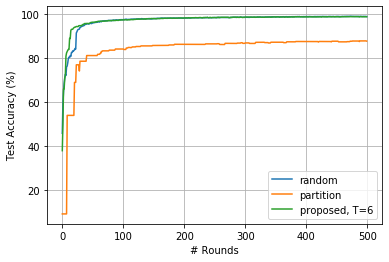

In [20]:
plt.plot(acc_test_arr[0,0,:], label='random')
plt.plot(acc_test_arr_partition[:], label='partition')
plt.plot(acc_test_arr_Proposed_N120_K12_T6[:], label='proposed, T=6')
# plt.plot(acc_test_arr_Proposed_N120_K12_T4[:], label='proposed, T=4')
# plt.plot(acc_test_arr_Proposed_N120_K12_T3[:], label='proposed, T=3')
# plt.plot(acc_test_arr_Proposed_N40_K8_T2[:], label='proposed, T=2')
# plt.plot(mean_fairness_N120_pdiff_noSelection[3,:], label='proposed, T=4')
# plt.plot(mean_fairness_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_fairness_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('# Rounds')
# plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()